In [2]:
#import package
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
from scipy import stats

from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

import xgboost as xg

Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 89.1/89.1 MB 282.9 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [7]:
df = pd.read_csv(r'C:\Users\AES TECH\Pictures\Project\archive (1)\Entry Level Project Sheet - 3.1-data-sheet-udemy-courses-web-development.csv')

In [8]:
#df = pd.read_csv('../input/udemy-courses-revenue-generation-and-course-anal/Entry Level Project Sheet - 3.1-data-sheet-udemy-courses-web-development.csv')
df.info()
Entry Level Project Sheet - 3.1-data-sheet-udemy-courses-web-development

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3676 entries, 0 to 3675
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   course_id            3676 non-null   int64  
 1   course_title         3676 non-null   object 
 2   url                  3676 non-null   object 
 3   price                3676 non-null   int64  
 4   num_subscribers      3676 non-null   int64  
 5   num_reviews          3676 non-null   int64  
 6   num_lectures         3676 non-null   int64  
 7   level                3676 non-null   object 
 8   rating               3676 non-null   float64
 9   content_duration     3676 non-null   float64
 10  published_timestamp  3676 non-null   object 
 11  subject              3676 non-null   object 
 12  Date                 3676 non-null   object 
 13  Free/Paid            3676 non-null   object 
dtypes: float64(2), int64(5), object(7)
memory usage: 402.2+ KB


In [9]:
df.head()

,course_id,course_title,url,price,num_subscribers,num_reviews,num_lectures,level,rating,content_duration,published_timestamp,subject,Date,Free/Paid
0,41295,Learn HTML5 Programming From Scratch,https://www.udemy.com/learn-html5-programming-...,0,268923,8629,45,Beginner Level,0.82,10.5,2013-02-14T07:03:41Z,Web Development,2013-02-14,Free
1,59014,Coding for Entrepreneurs Basic,https://www.udemy.com/coding-for-entrepreneurs...,0,161029,279,27,Expert Level,0.69,3.5,2013-06-09T15:51:55Z,Web Development,2013-06-09,Free
2,625204,The Web Developer Bootcamp,https://www.udemy.com/the-web-developer-bootcamp/,200,121584,27445,342,Beginner Level,0.89,43.0,2015-11-02T21:13:27Z,Web Development,2015-11-02,Paid
3,173548,Build Your First Website in 1 Week with HTML5 ...,https://www.udemy.com/build-your-first-website...,0,120291,5924,30,All Levels,0.78,3.0,2014-04-08T16:21:30Z,Web Development,2014-04-08,Free
4,764164,The Complete Web Developer Course 2.0,https://www.udemy.com/the-complete-web-develop...,200,114512,22412,304,Beginner Level,0.55,30.5,2016-03-08T22:28:36Z,Web Development,2016-03-08,Paid


### Great, a complete dataset.

# 2️⃣ EDA

In [10]:
sns.set(rc={'axes.facecolor':'black',
    'figure.facecolor':'black',
    'text.color':'white',
    'xtick.color':'white',
    'ytick.color':'white',
    'axes.labelcolor':'white'})

In [11]:
print(min(df['Date']),'-',max(df['Date']))

2011-07-09 - 2017-07-06


### This is the date range that covers this dataset.

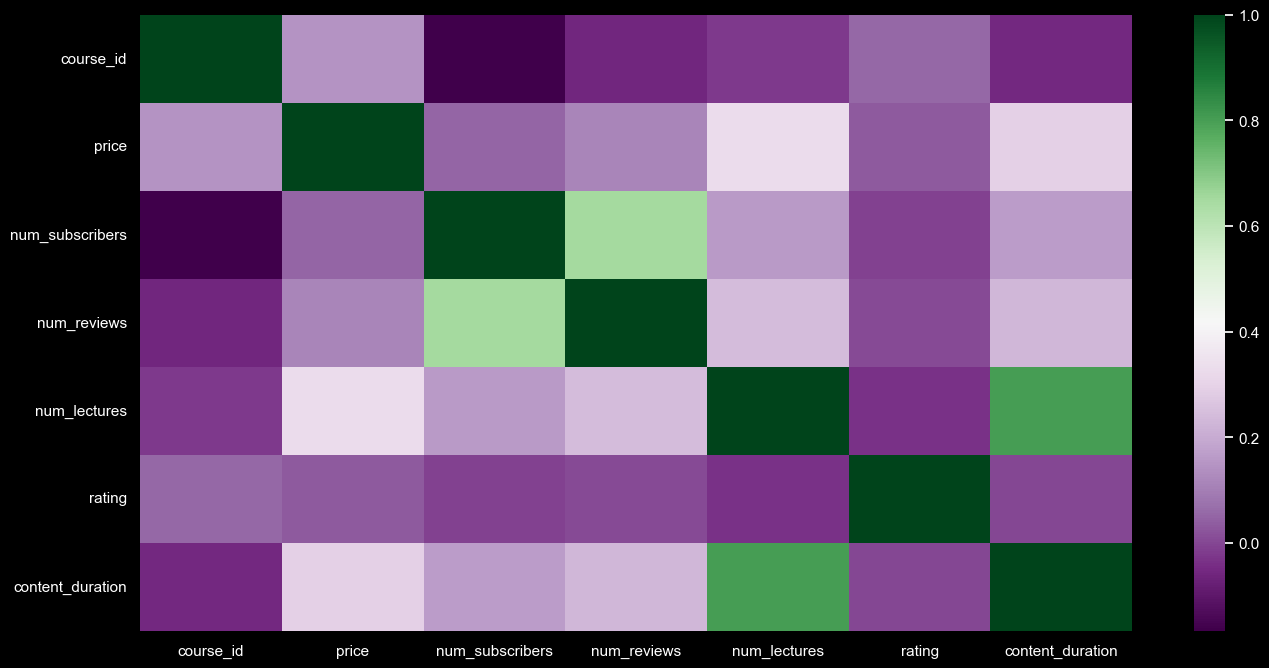

In [12]:
plt.figure(figsize=(16,8))
sns.heatmap(df.corr(),cmap='PRGn')
plt.show()

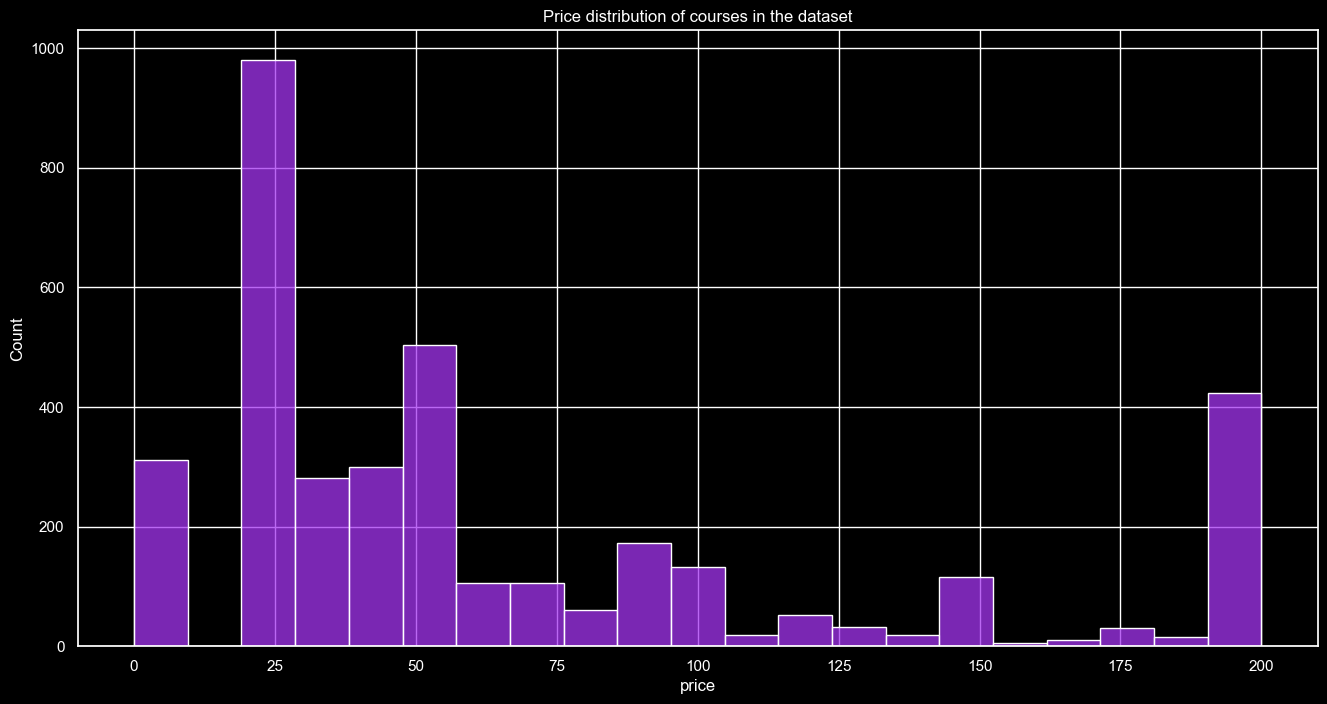

Mean:66.11534276387377


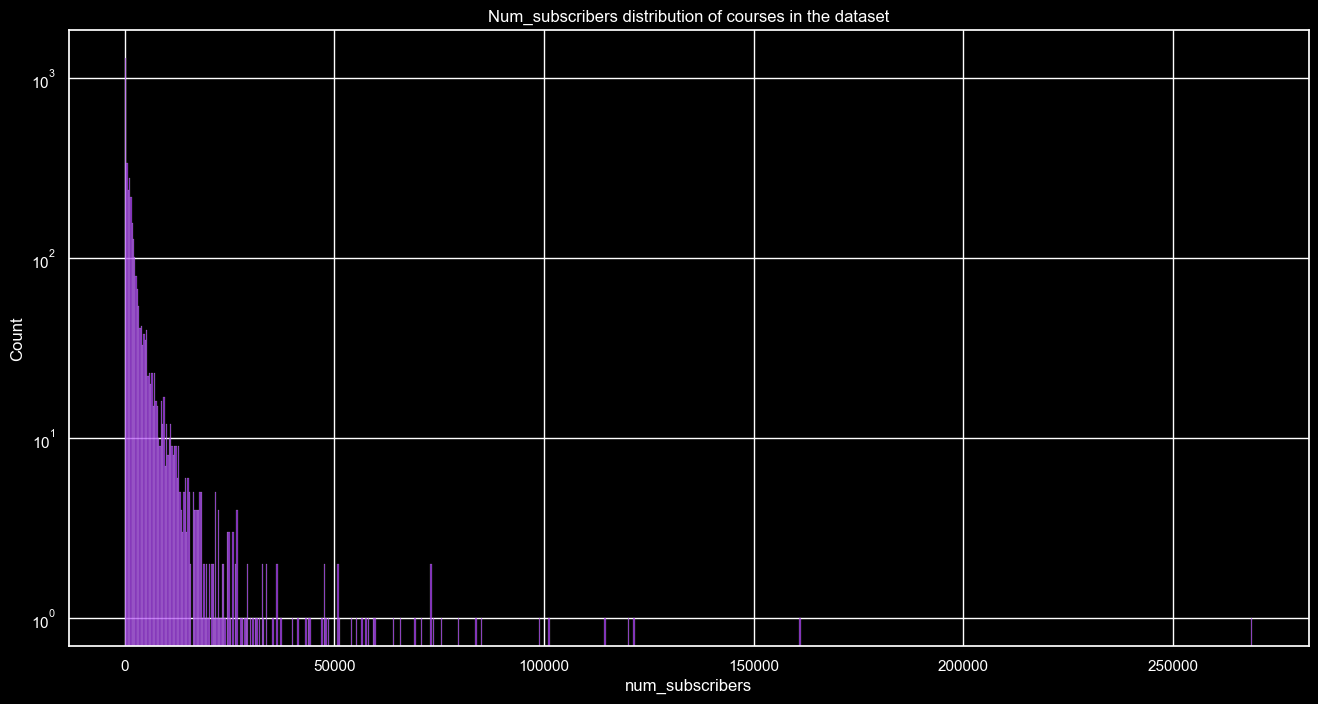

Mean:3199.260881392818


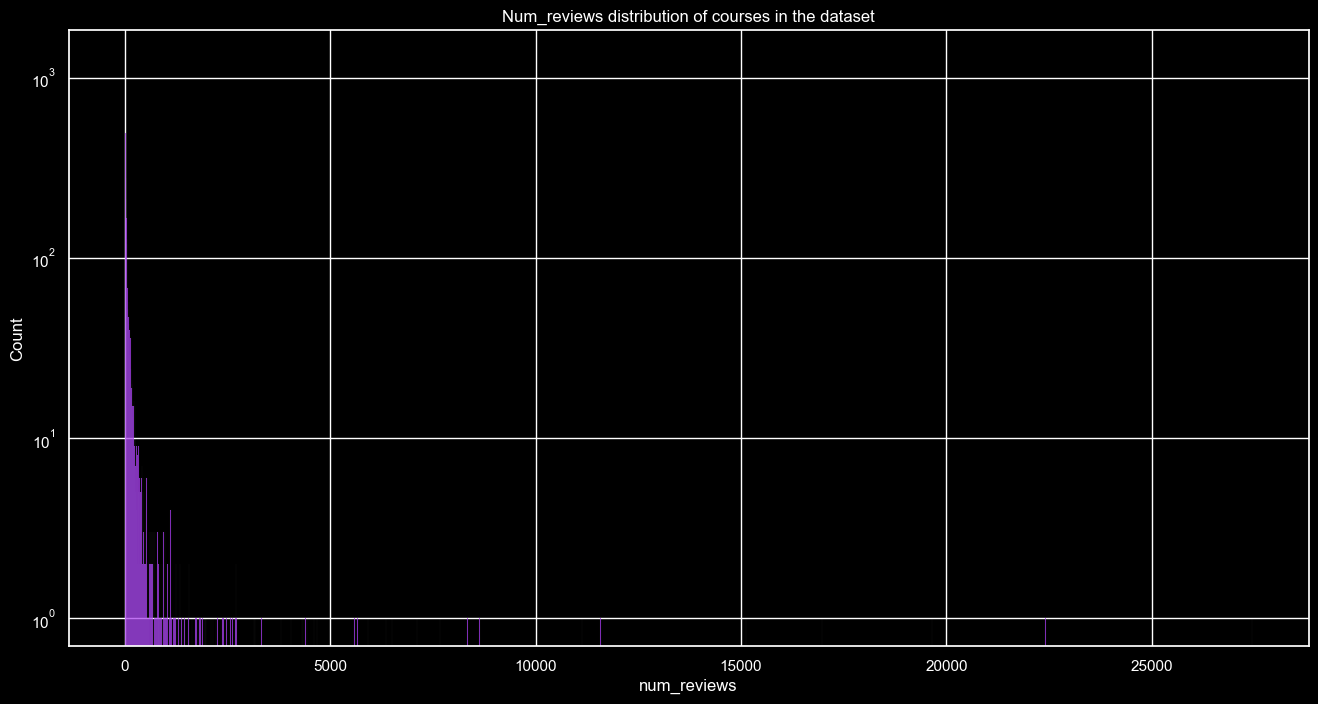

Mean:156.30984766050054


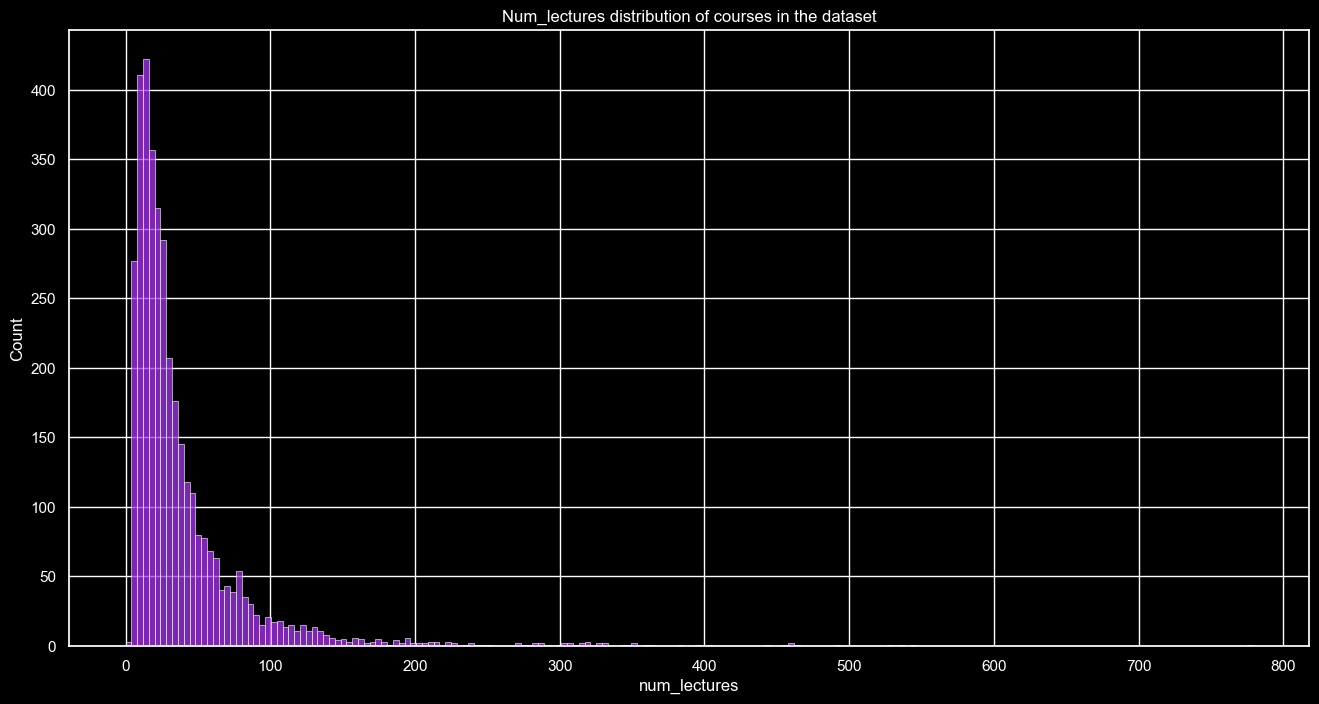

Mean:40.129760609357994


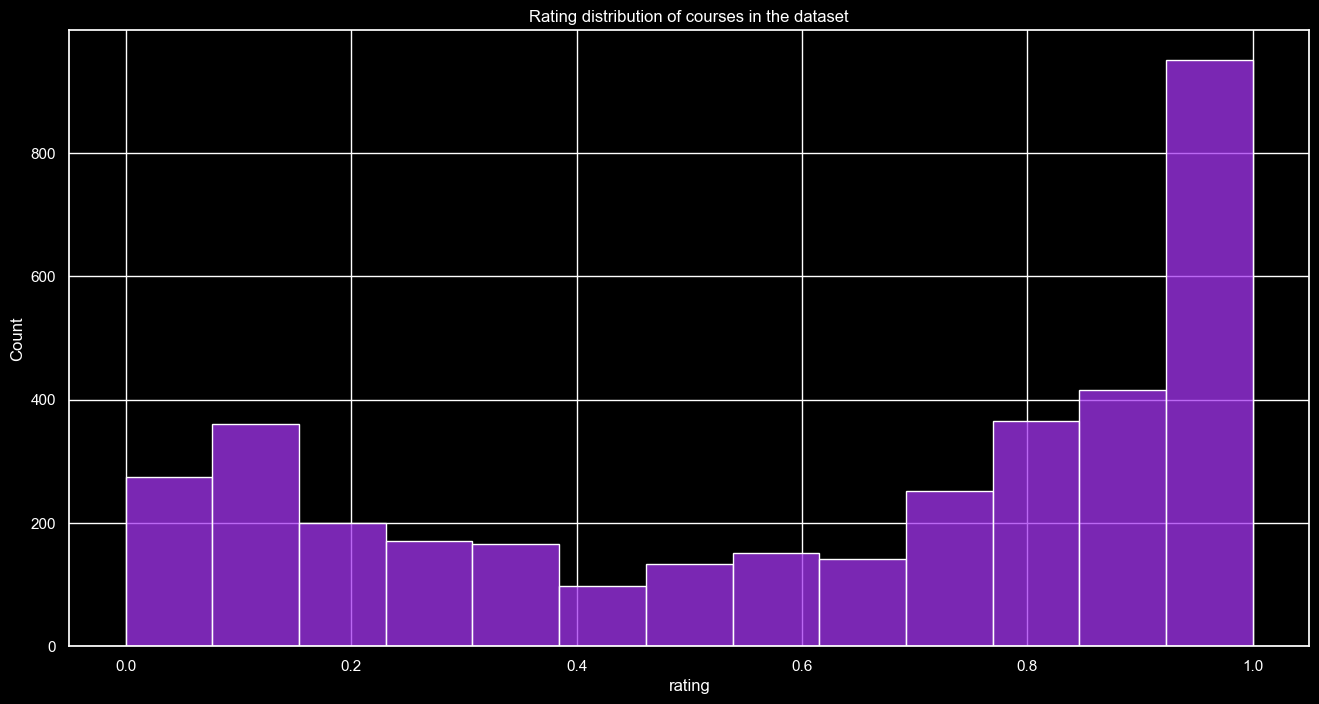

Mean:0.6108677910772597


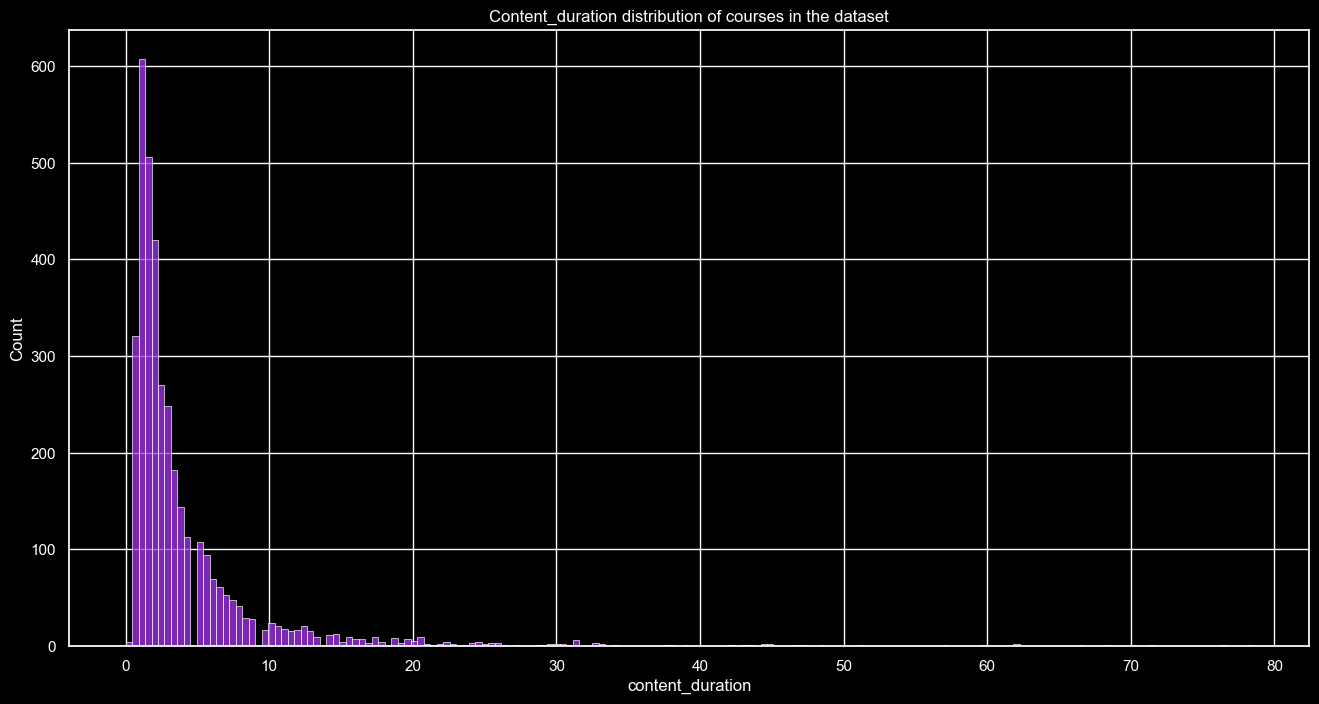

Mean:4.096137105549593


In [13]:
for column in df.columns:
    if df[column].dtype != 'object' and column != 'course_id':
        plt.figure(figsize=(16,8))
        sns.histplot(data=df,x=column,color='#A435F0')
        if np.std(df[column]) > 100:
            plt.yscale('log')
        else:
            plt.yscale('linear')
        plt.title(label= column.capitalize()+' distribution of courses in the dataset')
        plt.show()
        print('Mean:'+str(np.mean(df[column])))

### Most courses are between 25 and 50 with a few very high priced courses and some in between.

### The majority of courses have subscriber counts between 0 and 25000.

### The number of reviews fit within around 1000, and past that there are very few courses with significant reviews.

### The number of lectures per course rarely exceeds 100.

### The rating attribute sees a large skew towards 1.0.

### A large number of courses have a content duration of less than 10. 

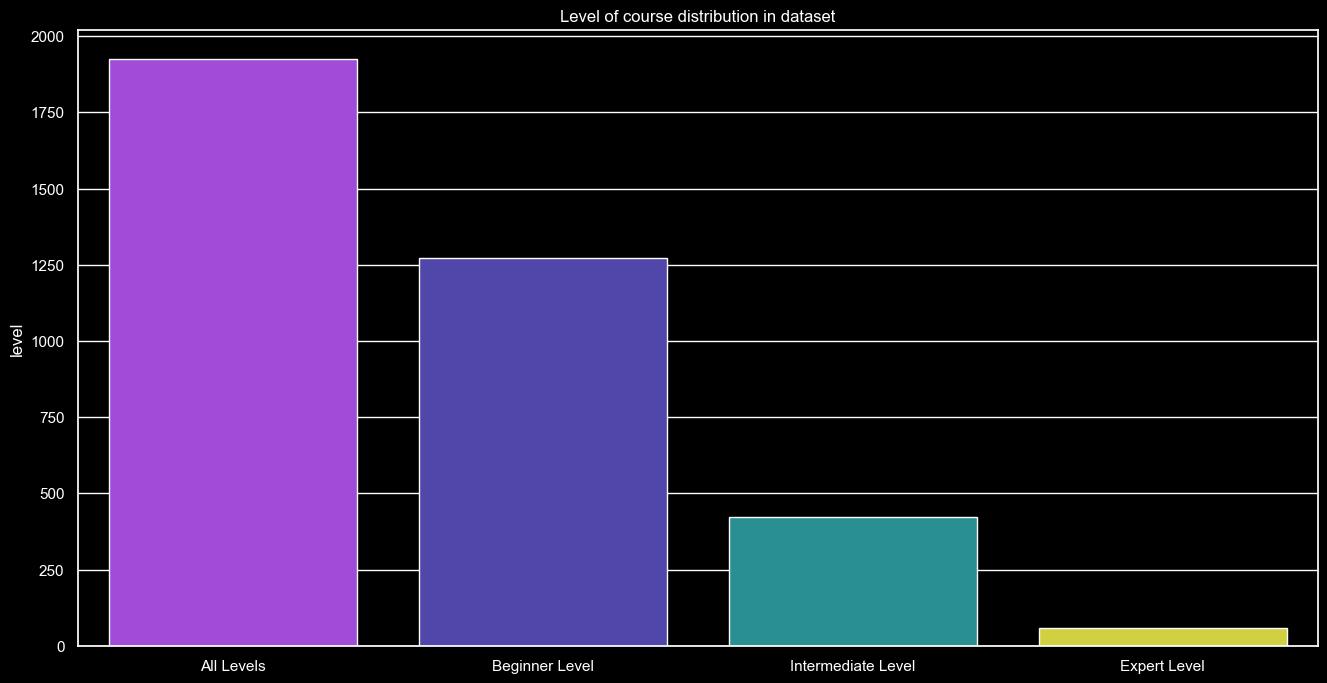

In [14]:
colors = ['#A435F0','#4435BB','#199FA3','#E9E729']
plt.figure(figsize=(16,8))
sns.barplot(x=df['level'].value_counts().keys(),
            y=df['level'].value_counts(),palette=colors)
plt.title(label='Level of course distribution in dataset')
plt.show()

### Udemy appears to be geared towards beginners

In [15]:
levels = ['All Levels','Beginner Level','Intermediate Level','Expert Level']
numbers = []
for i in df['subject'].unique():
    tempDF = df[df['subject']==i]
    for j in levels:
        numbers.append([i,j,len(tempDF[tempDF['level']==j])])
data = {
    'Subject':[i[0] for i in numbers],
    'Level':[i[1] for i in numbers],
    'Count':[i[2] for i in numbers]
}
splitDF = pd.DataFrame(numbers,columns=['Subject','Level','Count'])

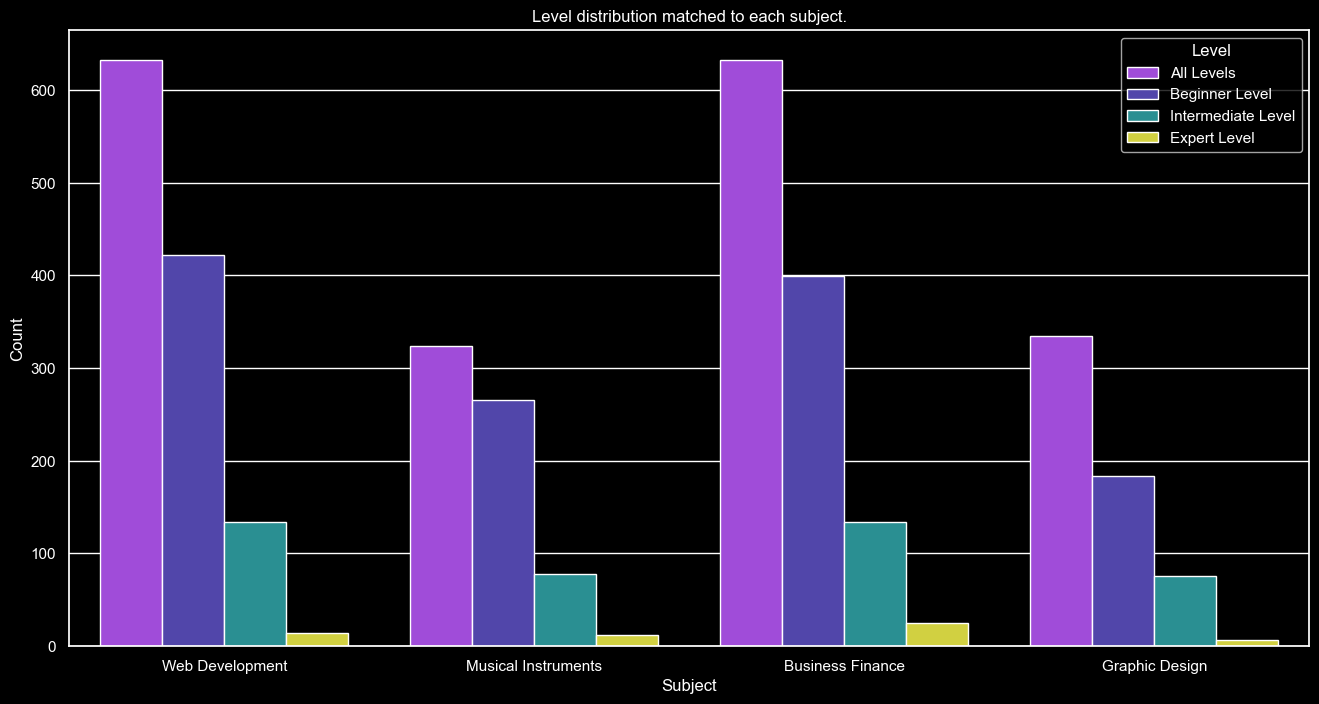

In [16]:
plt.figure(figsize=(16,8))
sns.barplot(data=splitDF,x='Subject',y='Count',hue='Level',palette=colors)
plt.title(label='Level distribution matched to each subject.')
plt.show()

### No matter the subject Udemy seems to be more suited to beginners.

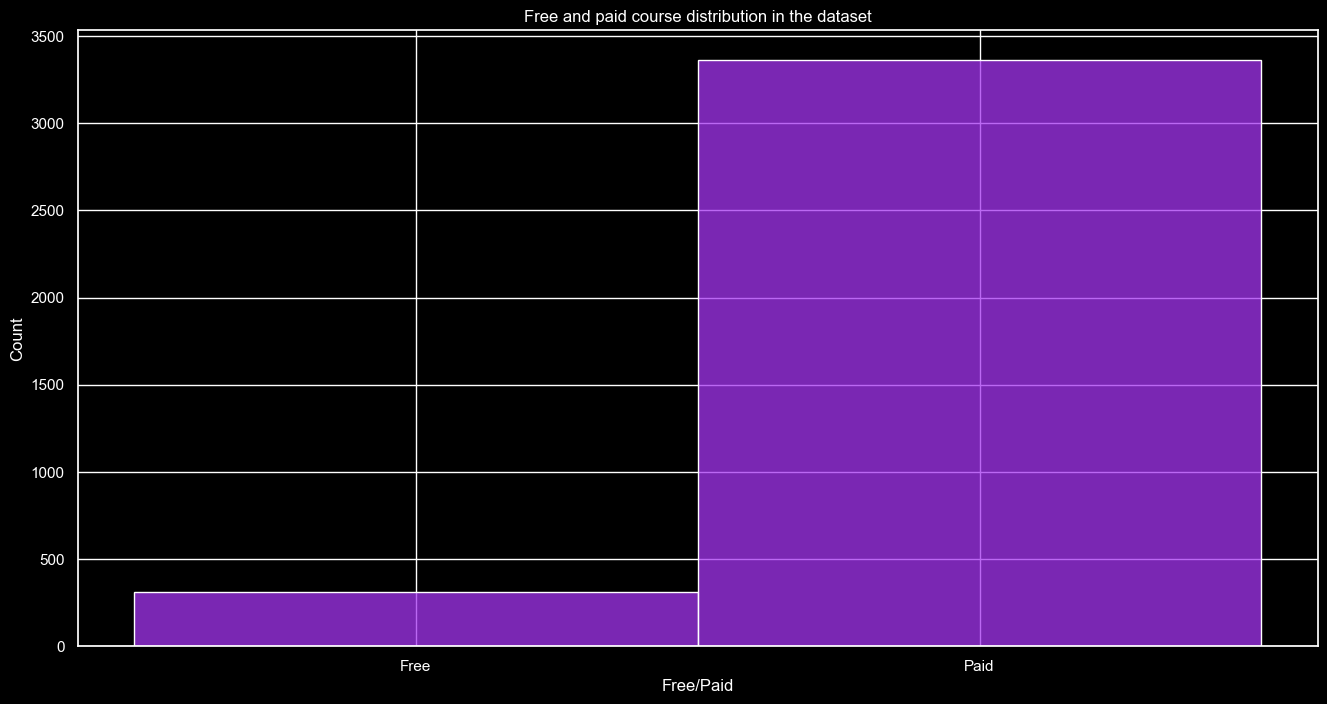

In [17]:
plt.figure(figsize=(16,8))
sns.histplot(data=df,x='Free/Paid',color='#A435F0')
plt.title(label='Free and paid course distribution in the dataset')
plt.show()

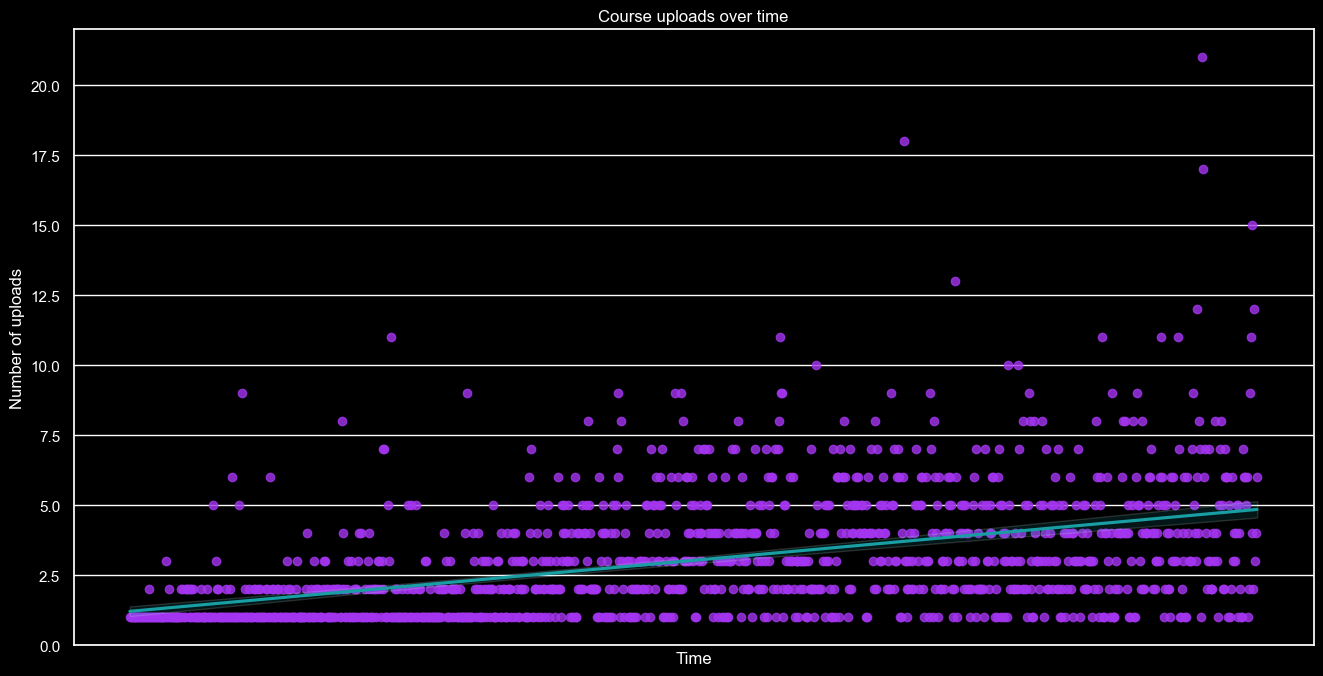

In [18]:
totals = []
dates = df.Date.unique()
dates.sort()
for i in dates:
    tempDF = df[df['Date']==i]
    totals.append([i,len(tempDF)])
plt.figure(figsize=(16,8))
sns.regplot(x=[i for i in range(len(totals))],
            y=[i[1] for i in totals],
            scatter_kws={'color': '#A435F0'}, line_kws={'color': '#199FA3'})
plt.title(label='Course uploads over time')
plt.xlabel(xlabel='Time')
plt.ylabel(ylabel='Number of uploads')
plt.xticks([])
plt.show()

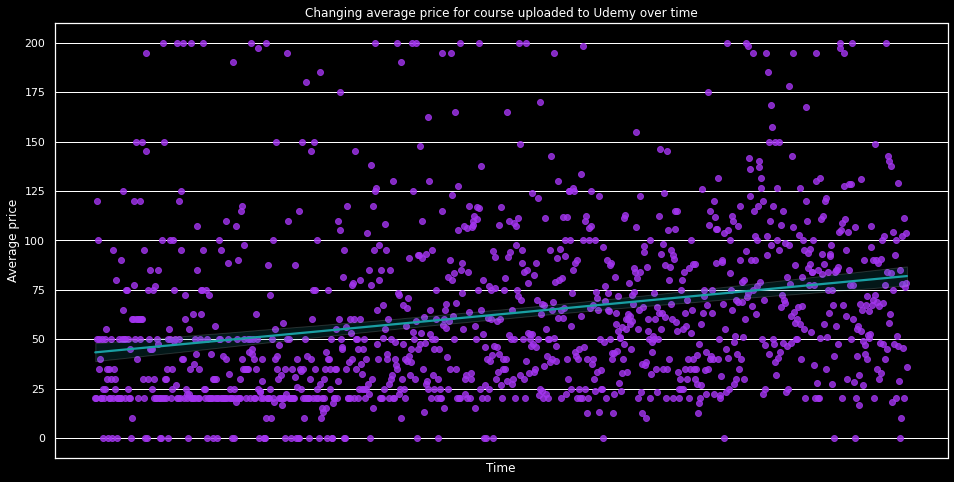

In [12]:
sums = []
for i in dates:
    tempDF= df[df.Date == i]
    sums.append([i,np.mean(tempDF['price'])])
plt.figure(figsize=(16,8))
sns.regplot(x=[i for i in range(len(sums))],
            y=[i[1] for i in sums],
            scatter_kws={'color': '#A435F0'}, line_kws={'color': '#199FA3'})
plt.xlabel(xlabel='Time')
plt.ylabel(ylabel='Average price')
plt.title(label='Changing average price for course uploaded to Udemy over time')
plt.xticks([])
plt.show()

### The market for course on Udemy has become more saturated over time. The rate at which courses are being uploaded is increasing. The average price for a course has gone up and the number of free courses uploaded is going down.

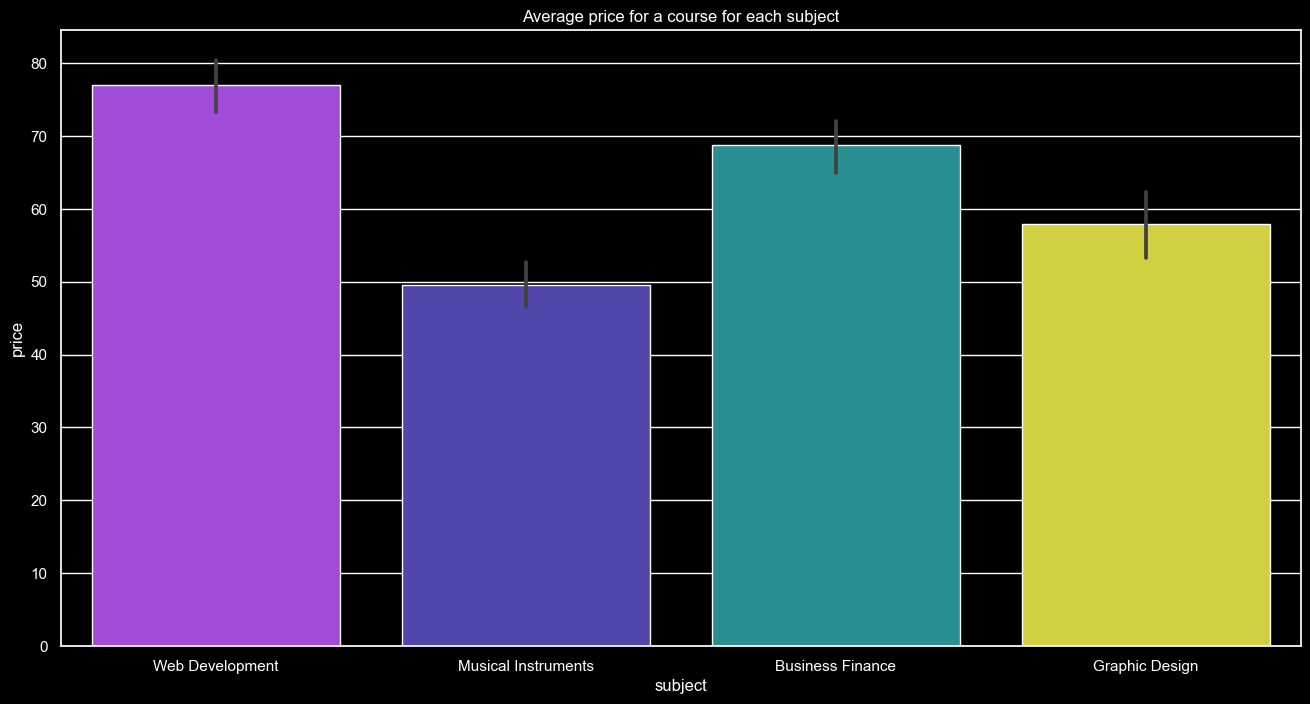

In [19]:
plt.figure(figsize=(16,8))
sns.barplot(data=df,x='subject',y='price',palette=colors)
plt.title(label='Average price for a course for each subject')
plt.show()

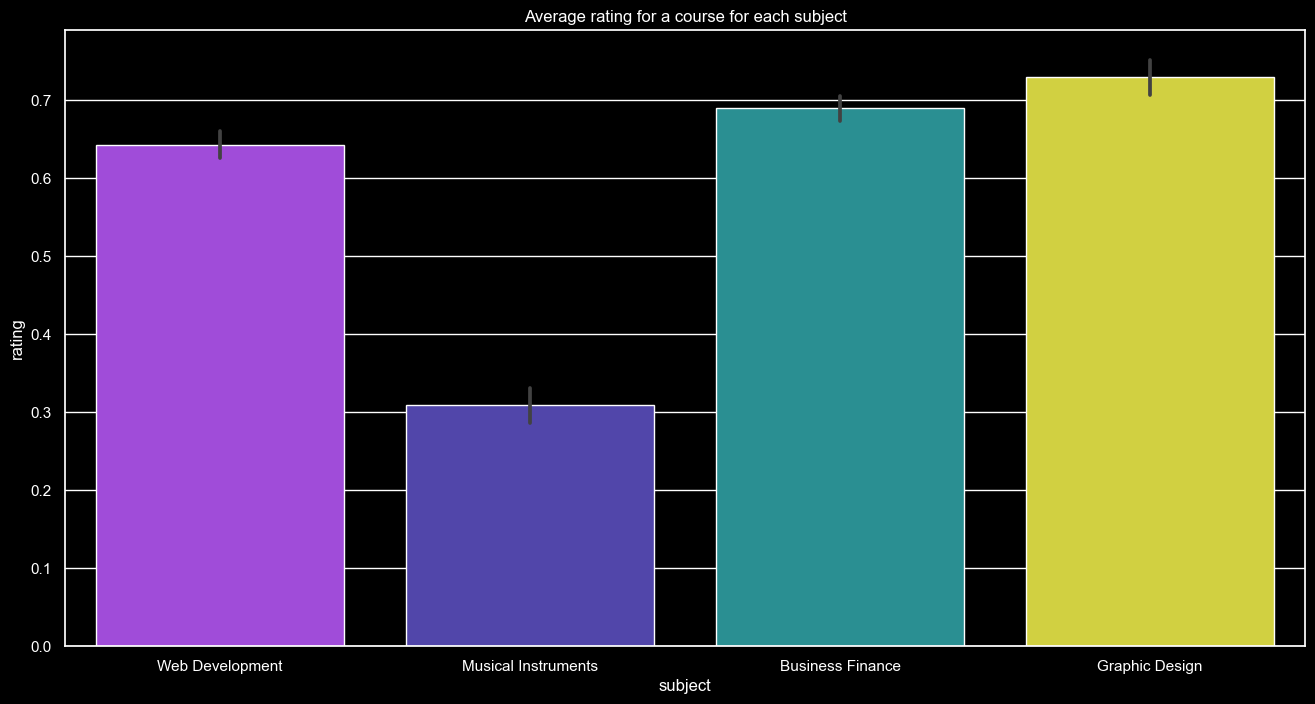

In [20]:
plt.figure(figsize=(16,8))
sns.barplot(data=df,x='subject',y='rating',palette=colors)
plt.title(label='Average rating for a course for each subject')
plt.show()

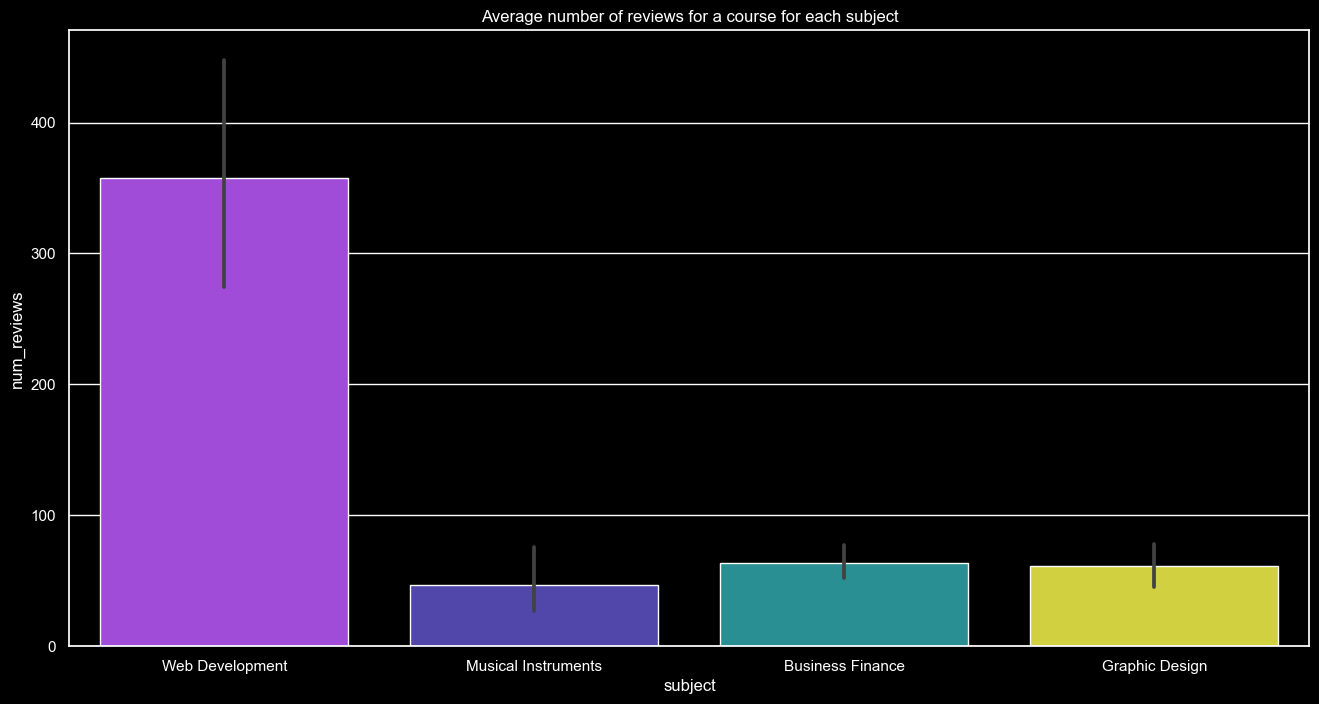

In [21]:
plt.figure(figsize=(16,8))
sns.barplot(data=df,x='subject',y='num_reviews',palette=colors)
plt.title(label='Average number of reviews for a course for each subject')
plt.show()

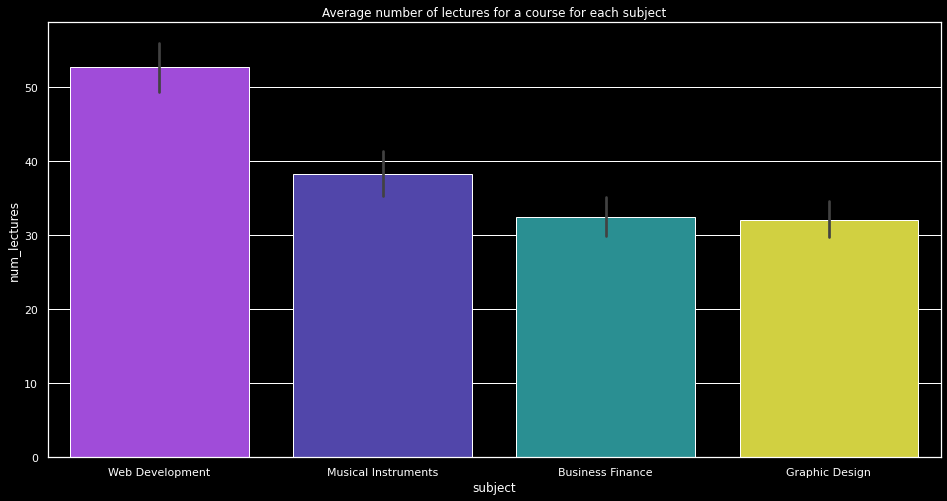

In [16]:
plt.figure(figsize=(16,8))
sns.barplot(data=df,x='subject',y='num_lectures',palette=colors)
plt.title(label='Average number of lectures for a course for each subject')
plt.show()

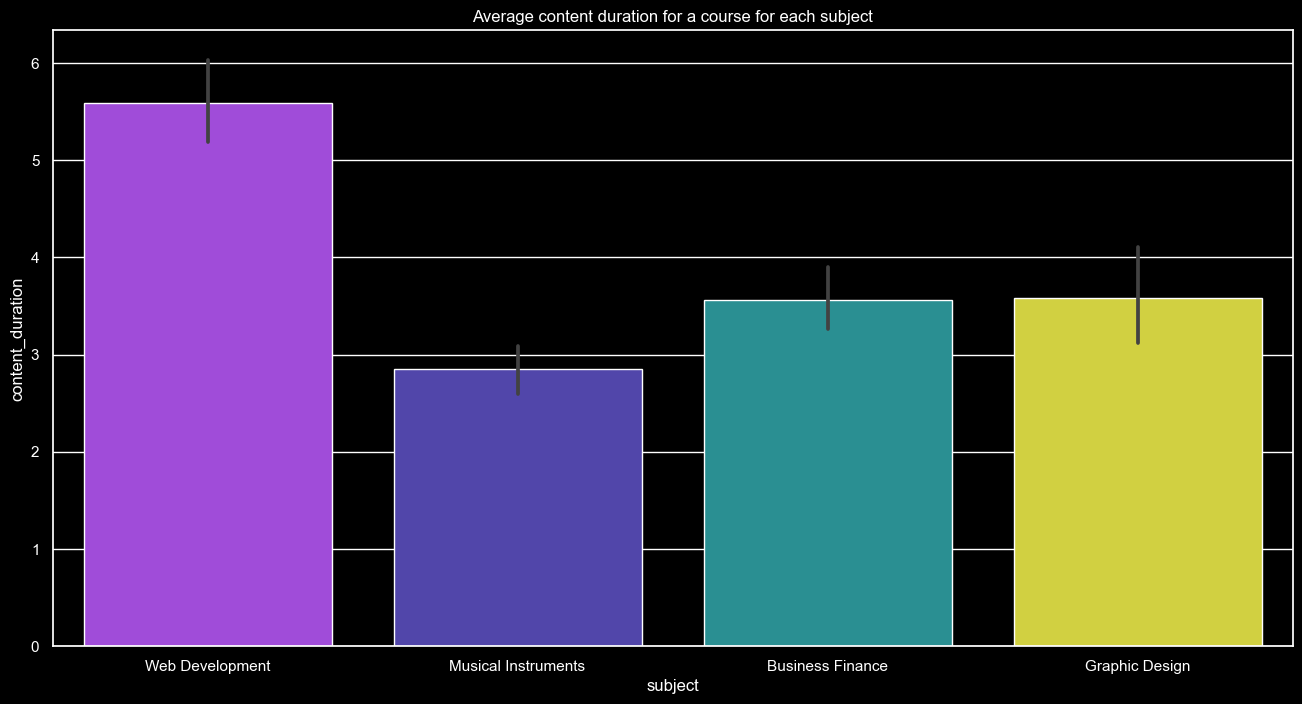

In [22]:
plt.figure(figsize=(16,8))
sns.barplot(data=df,x='subject',y='content_duration',palette=colors)
plt.title(label='Average content duration for a course for each subject')
plt.show()

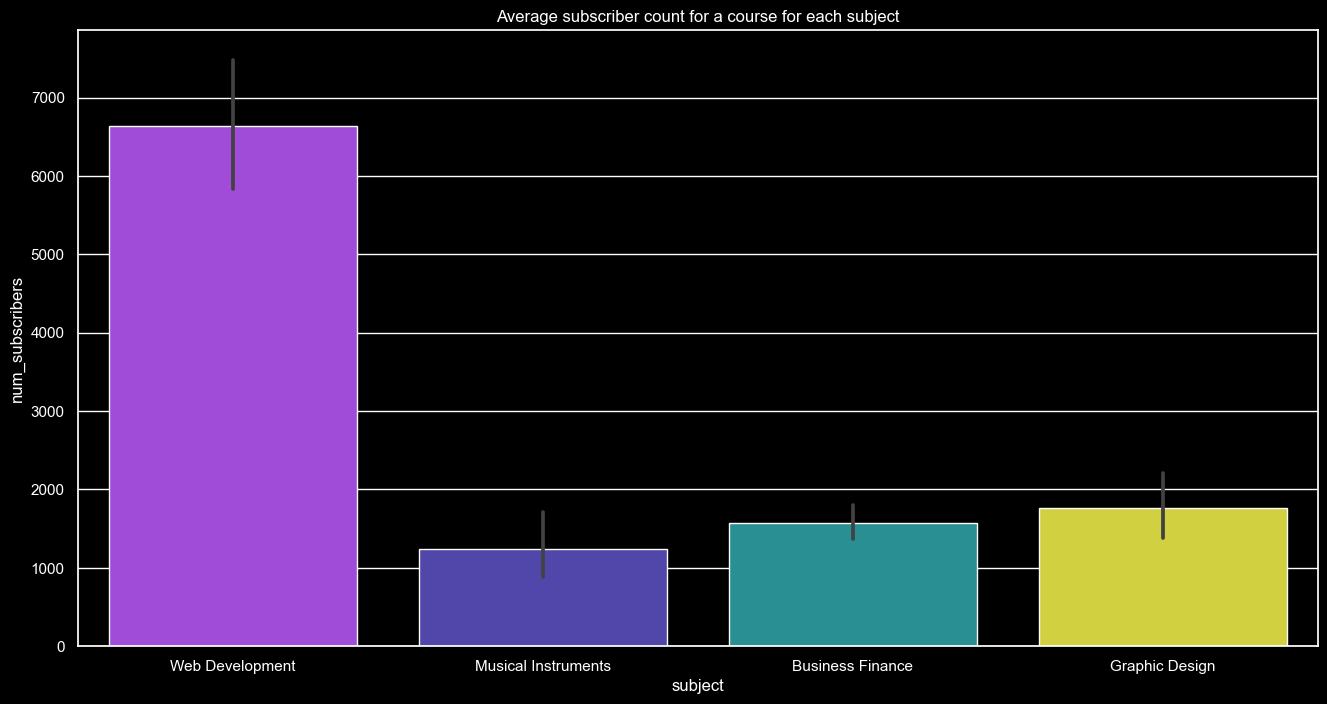

In [23]:
plt.figure(figsize=(16,8))
sns.barplot(data=df,x='subject',y='num_subscribers',palette=colors)
plt.title(label='Average subscriber count for a course for each subject')
plt.show()

### Music courses cost the least and are rated on average the worst out of all the subjects.

### Students get the most lectures and content from a web development course out of all the subjects. It is also by far the most popular subject on this dataset.

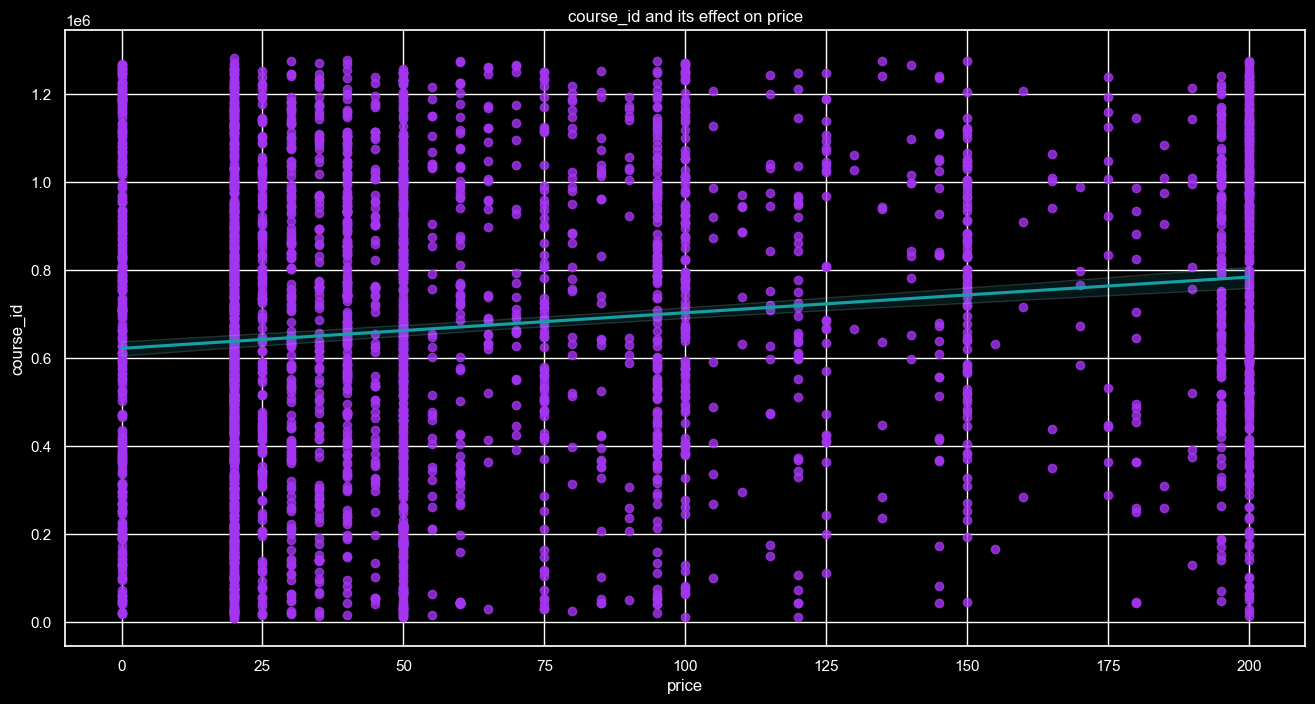

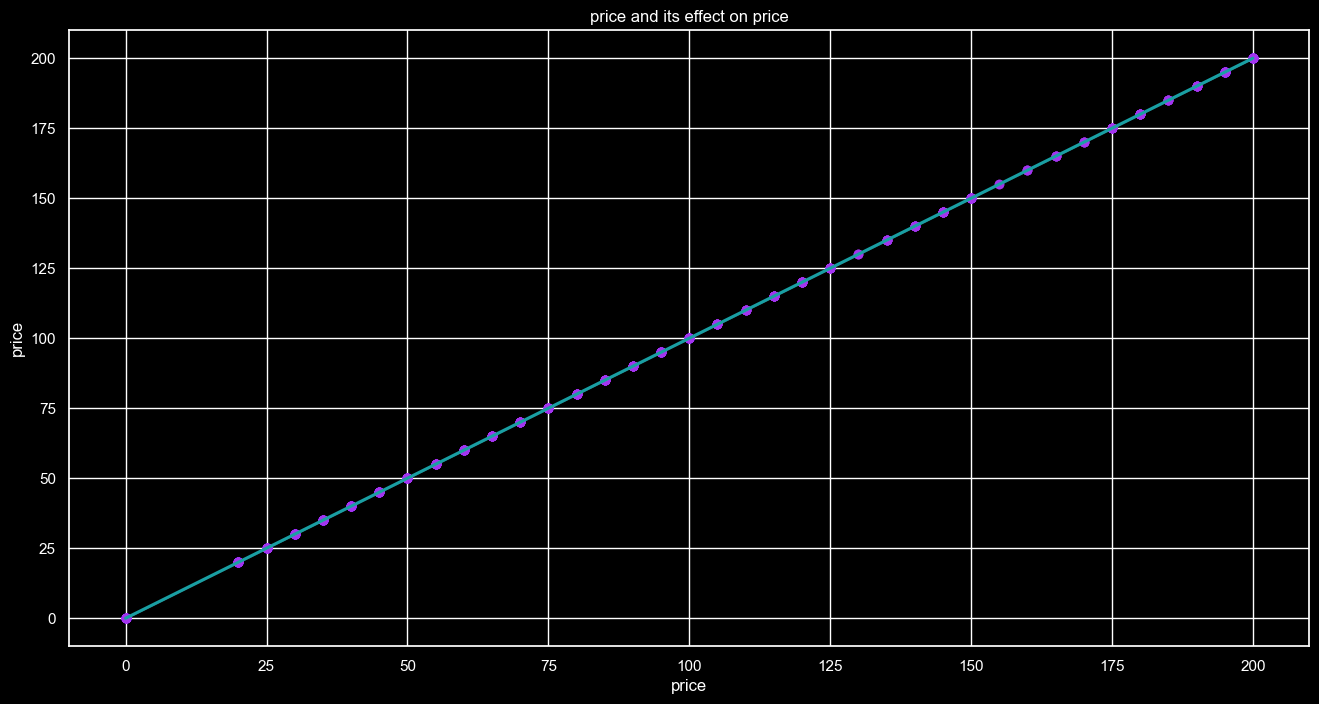

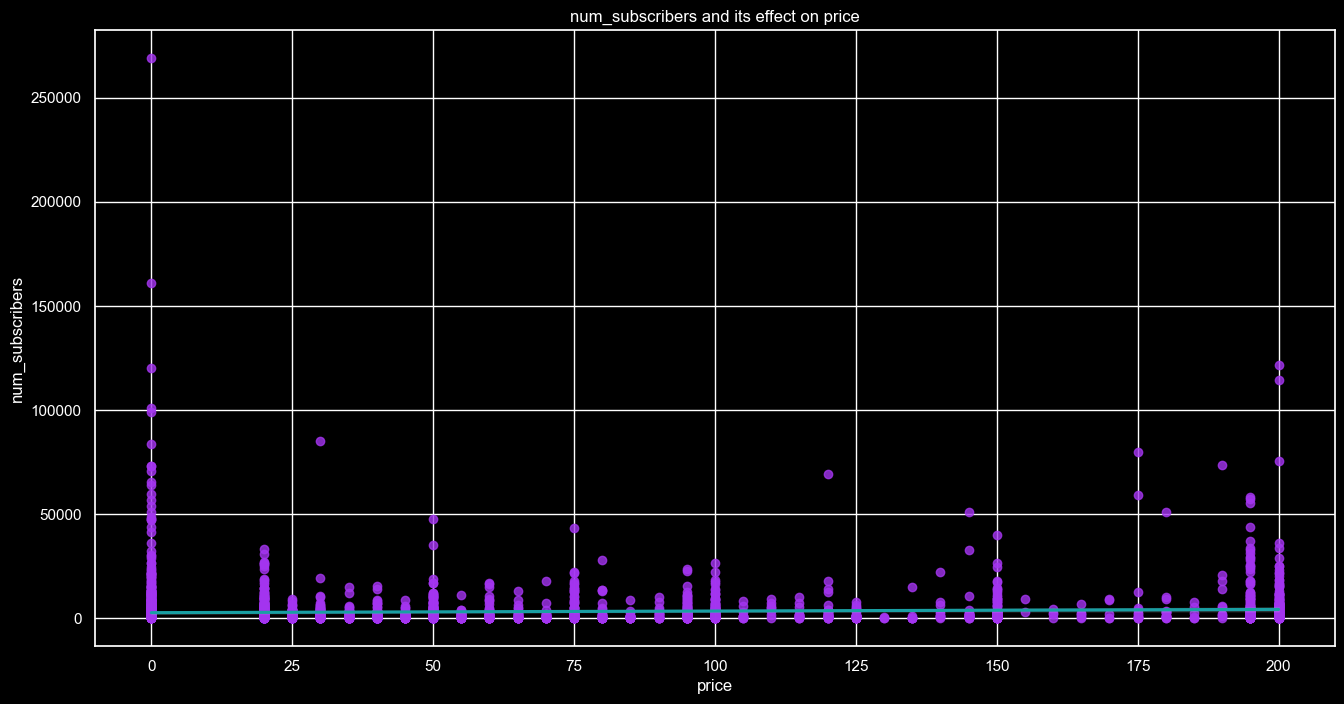

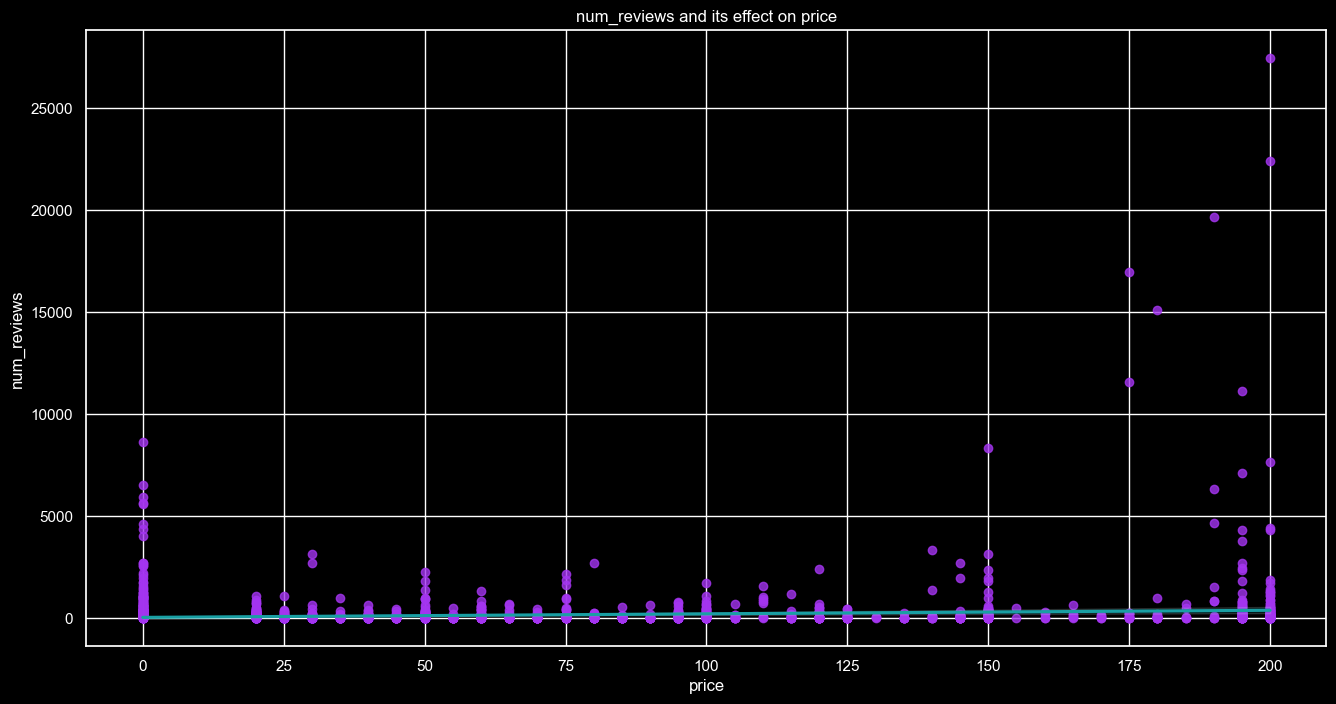

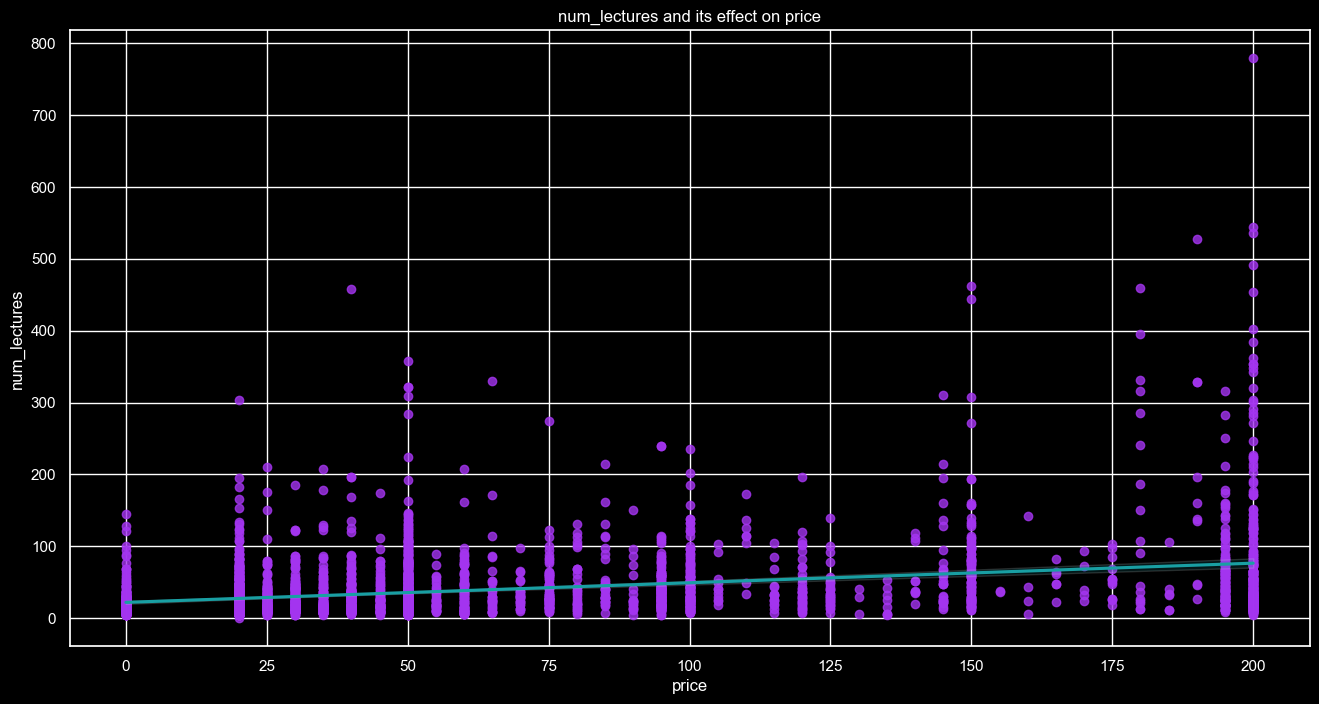

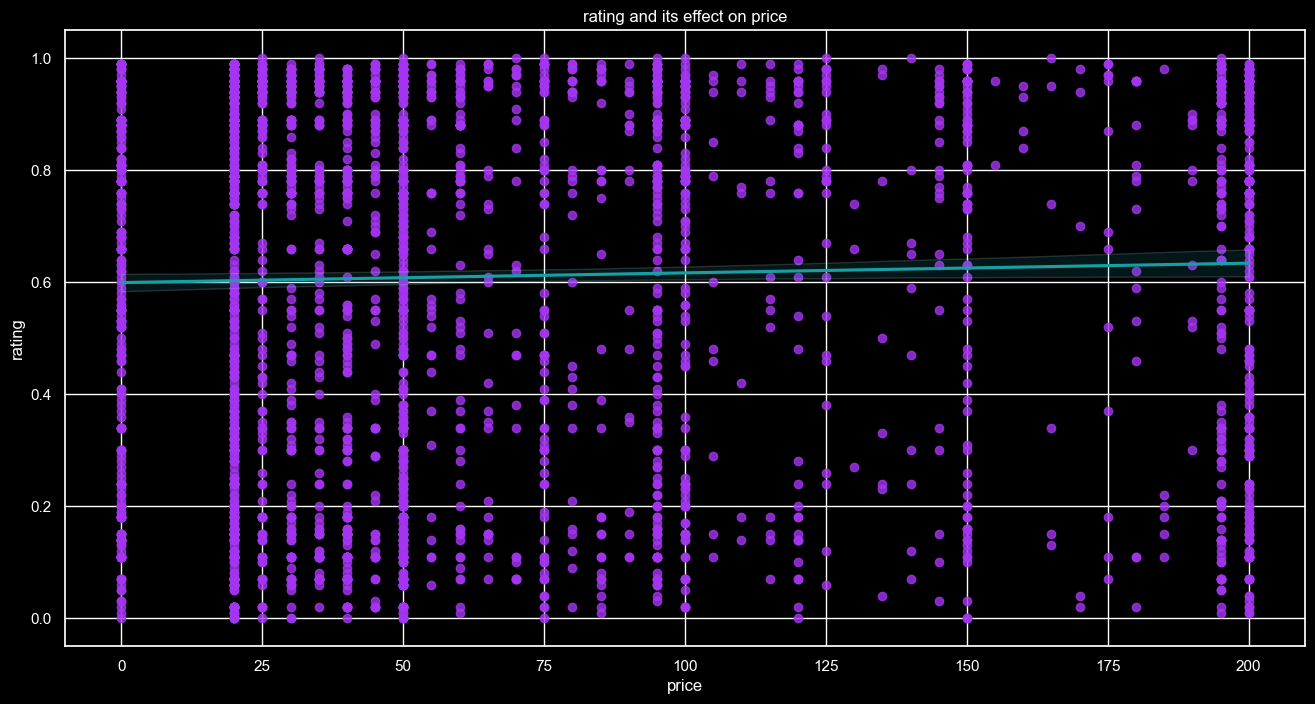

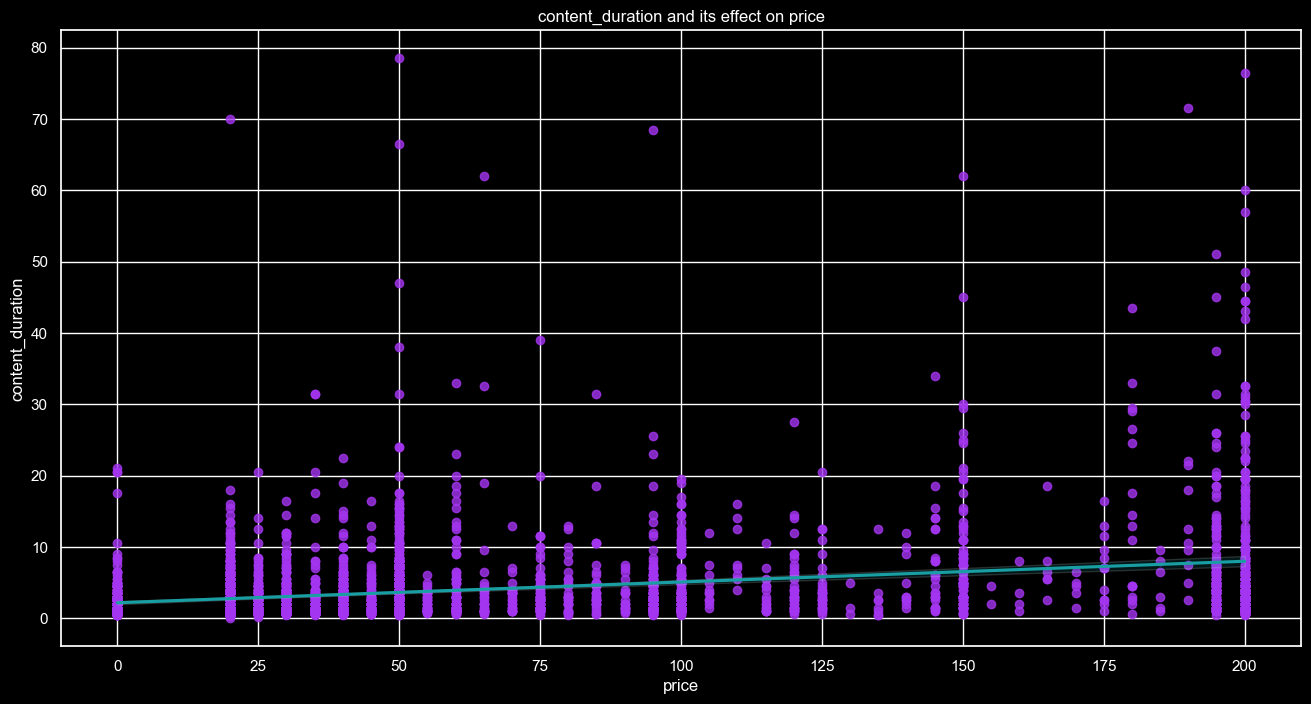

In [24]:
for i in df.columns:
    if df[i].dtype != 'object':
        plt.figure(figsize=(16,8))
        sns.regplot(data=df,x='price',y=i,
                   scatter_kws={'color': '#A435F0'}, line_kws={'color': '#199FA3'})
        plt.title(label=i+' and its effect on price')
        plt.show()

### Only some marginal correlation between some of these attributes and price.

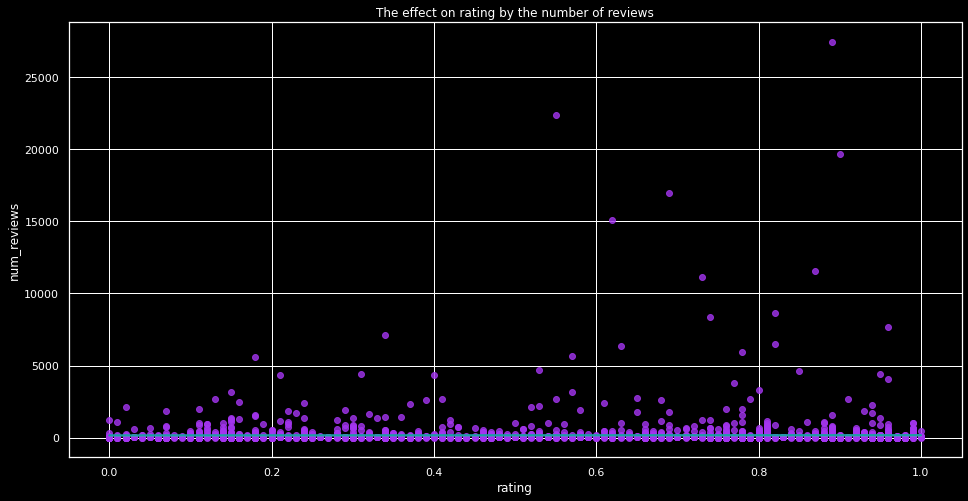

In [20]:
plt.figure(figsize=(16,8))
sns.regplot(data=df,x='rating',y='num_reviews',
           scatter_kws={'color': '#A435F0'}, line_kws={'color': '#199FA3'})
plt.title(label='The effect on rating by the number of reviews')
plt.show()

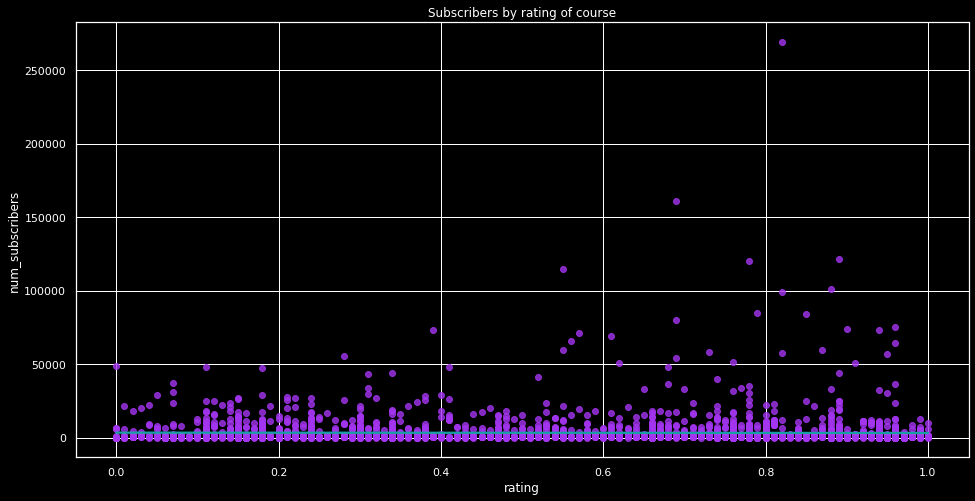

In [21]:
plt.figure(figsize=(16,8))
sns.regplot(data=df,x='rating',y='num_subscribers',
           scatter_kws={'color': '#A435F0'}, line_kws={'color': '#199FA3'})
plt.title(label='Subscribers by rating of course')
plt.show()

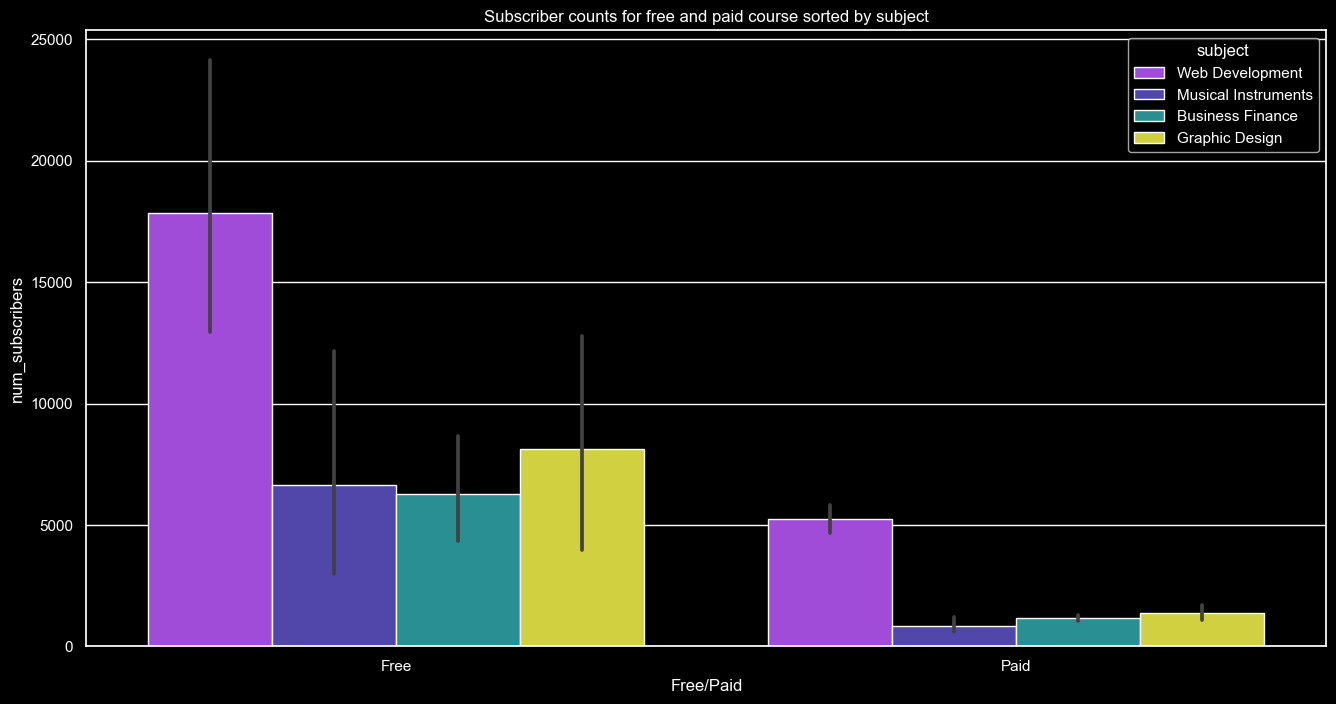

In [25]:
plt.figure(figsize=(16,8))
sns.barplot(data=df,x='Free/Paid',y='num_subscribers',hue='subject',palette=colors)
plt.title(label='Subscriber counts for free and paid course sorted by subject')
plt.show()

### We now now that the majority of subscribers belong to free courses and of those free courses, web development is the most popular. 

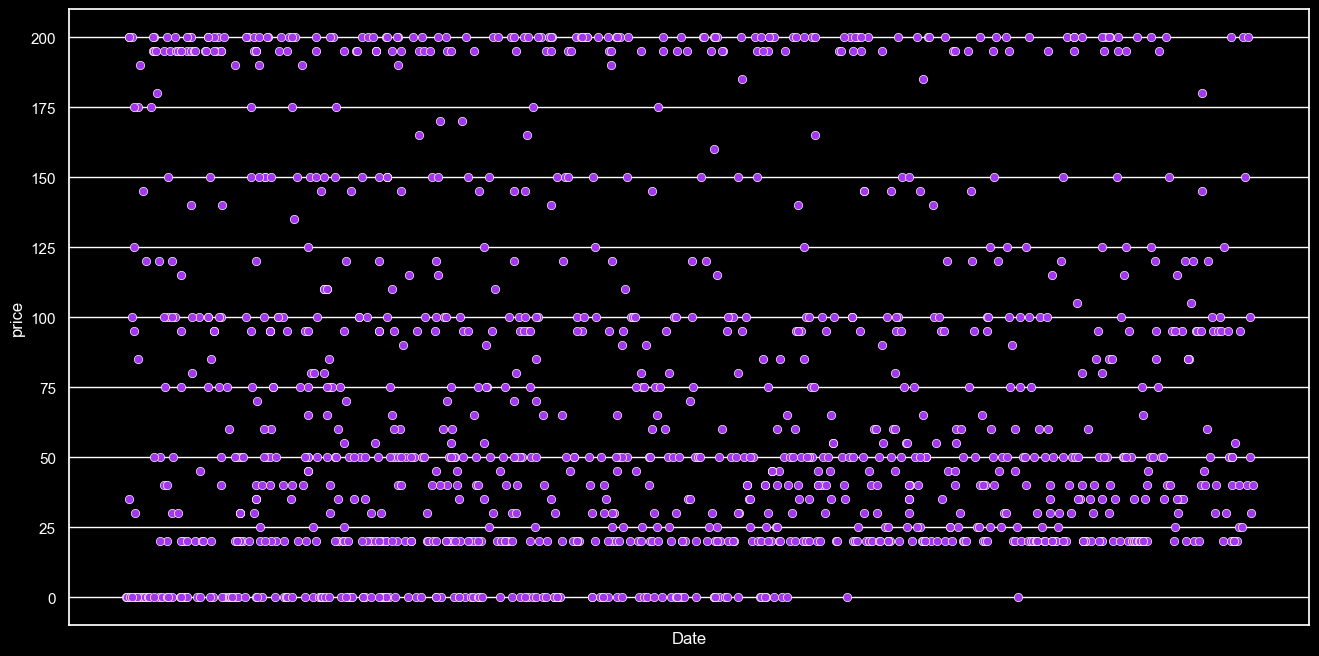

In [26]:
tempDF = df[df['subject']=='Web Development']
plt.figure(figsize=(16,8))
sns.scatterplot(data=tempDF,x='Date',y='price',color='#A435F0')
plt.xticks([])
plt.show()

### We know that the majority of subscribers choose free courses in web development and that most free courses are fairly old. This means that a lot of subscribers are learning older material.

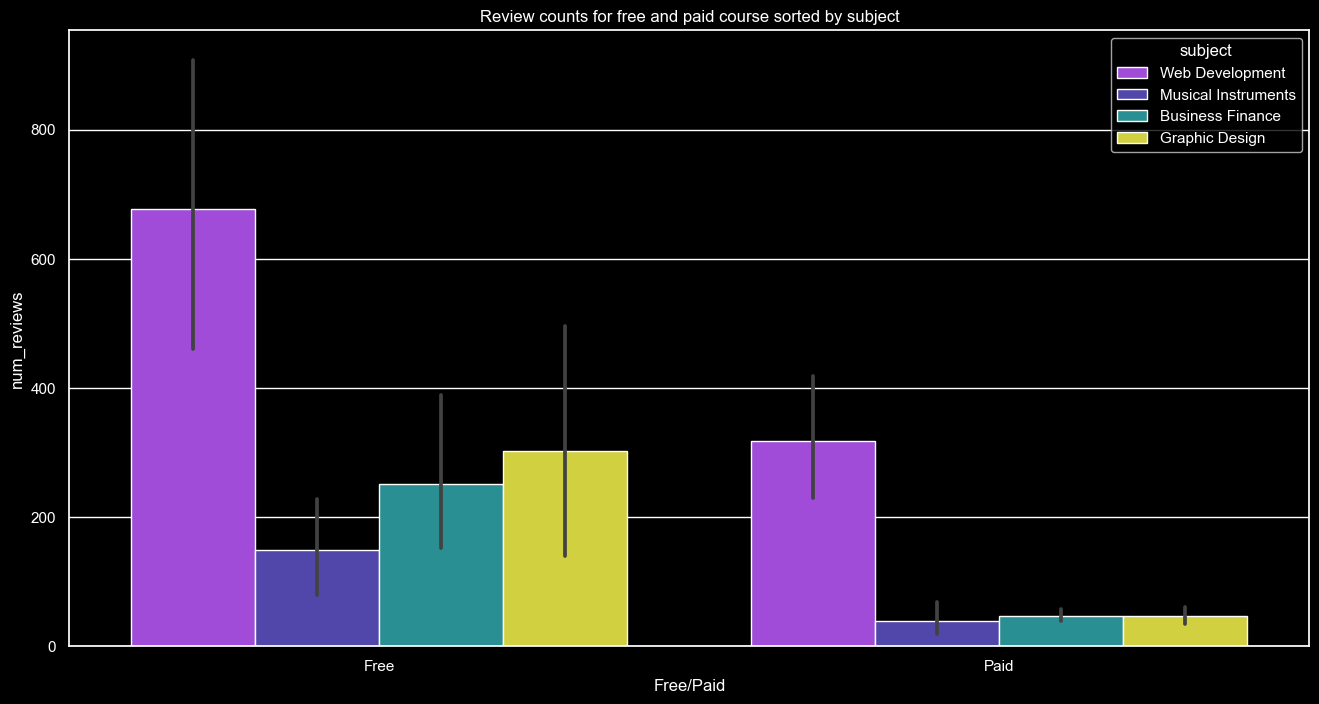

In [27]:
plt.figure(figsize=(16,8))
sns.barplot(data=df,x='Free/Paid',y='num_reviews',hue='subject',palette=colors)
plt.title(label='Review counts for free and paid course sorted by subject')
plt.show()

## Revenue feature

In [28]:
revenue = []
for i in range(len(df)):
    revenue.append(df.loc[i]['num_subscribers'] * df.loc[i]['price'])
df['estimated_revenue'] = revenue
df['estimated_revenue'].head()

0           0
1           0
2    24316800
3           0
4    22902400
Name: estimated_revenue, dtype: int64

### The revenue feature does not hold true to real life as Udemy takes a percentage for hosting the course on the website as well as the fact that courses are often on sale. I would take the revenue with a large pinch of salt.

# 3️⃣ Web scraping the authors of the Udemy courses.

## I will be adding the author of the course to this dataset by scraping the url. I have commented the code out as I don't want to run it every time.

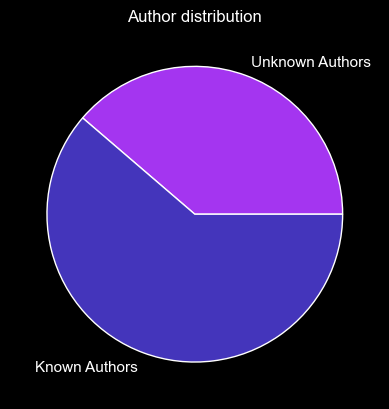

In [29]:
# from bs4 import BeautifulSoup
# import requests
# from tqdm import tqdm
# authors = []
# for i in tqdm(df['url']):
#     html = requests.get(i).text
#     soup = BeautifulSoup(html, "html.parser")
#     change = soup.find_all('div',class_='instructor-links--instructor-links--3d8_F')
#     author = 'Unknown'
#     try:
#         author = change[0].text
#         author = ' '.join(author.split(' ')[2:])
#         author = author.split(',')[0]
#         authors.append(author)
#     except:
#         authors.append('Unknown')
authors = ['Eduonix Learning Solutions', 'Justin Mitchel', 'Colt Steele', 'Ryan Bonhardt', 'Rob Percival', 'Unknown', 'Jonas Schmedtmann', 'Unknown', 'Brad Hussey', 'Anthony Alicea', 'Robin Hall', 'Maximilian Schwarzmüller', 'Unknown', 'Bradley Berger', 'Edwin Diaz', 'Unknown', 'Charles Hoskinson', 'Unknown', 'Eduonix Learning Solutions', 'Anthony Alicea', 'Anthony Alicea', 'Joe Parys', 'Vincent Turner', 'Joe Parys', 'Chad Neuman', 'Brad Hussey', 'John Ducas', 'Stephen Grider', 'Eduonix Learning Solutions', 'Infinite Skills', 'Donelli DiMaria', 'Erich Andreas', 'Lawrence Turton', 'Rawson Uddin', 'Jonas Schmedtmann', 'Brad Hussey', 'Brad Hussey', 'Mosh Hamedani', 'Joe Parys', 'Eduonix Learning Solutions', 'Phil Ebiner', 'Infinite Skills', 'Brad Hussey', 'Rob Percival', 'iMarket XL', 'Erich Andreas', 'Ermin Kreponic', 'Unknown', 'Joe Parys', 'Kalob Taulien', 'Stone River eLearning', 'Unknown', 'Patrick Schroeder', 'Peter Lynch', 'Edwin Diaz', 'Abhay Talreja', 'Laurence Svekis', 'Jonas Schmedtmann', 'Brian Gorman', 'Jaysen Batchelor', 'Edwin Diaz', 'Dollar Design School', 'MindMekka ®', 'TrueFire Guitar Lessons', 'Dollar Design School', 'Unknown', 'Patrick Schroeder', 'Partha Bhattacharya', 'Joe Parys', 'Laurence Svekis', 'Unknown', 'Tara Roskell', 'Evan Kimbrell', '365 Careers', 'Andrew Eddy', 'Marie Taylor', 'ClayDesk E-learning', 'Justin Mitchel', 'Mason G', 'John Bura', 'Irfan Dayan', 'Laurence Svekis', 'Jared Passey', '365 Careers', 'Laurence Svekis', 'Stephen Grider', 'Unknown', 'Michael Palmisano', 'Ryan Chenkie', 'Patrick Schroeder', 'EDUmobile Academy', 'Patrick Schroeder', 'Sanjay Patel', 'Eduonix Learning Solutions', 'Lawrence Turton', 'Mosh Hamedani', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Jason Whaling', 'Tao W.', 'Ryan Bonhardt', 'Maruti Makwana', 'Christine Maisel', 'John Bura', 'Jeremy Deighan - 250', 'John Bura', 'Dollar Design School', 'Laurence Svekis', 'Joe Parys', 'BrainyMoney and Son Han', 'Dan Wahlin', 'Uzochukwu Eddie Odozi', 'Laurence Svekis', 'Daniel Kalish', 'Maximilian Schwarzmüller', 'Laurence Svekis', 'Hoku Ho', 'Unknown', 'Maximilian Schwarzmüller', 'Unknown', 'Infinite Skills', 'Unknown', 'Justin Mitchel', 'Kirill Eremenko', 'David Joseph Katz', 'Patrick Schroeder', 'Laurence Svekis', 'Stone River eLearning', 'Unknown', 'Stone River eLearning', 'Luca Moschini', 'Justin Mitchel', 'John Bura', 'Jazeb Akram', 'Daniel Kalish', 'Chris du Toit', 'Neil Fontaine', 'RefactorU LLC', 'Michael Bowen', 'Laurence Svekis', 'Derrick Mitchell', 'John Purcell', 'Eduonix Learning Solutions', 'Unknown', 'Brian Gorman', 'Unknown', 'Unknown', 'Laurence Svekis', 'Eduonix Learning Solutions', 'Unknown', 'Unknown', 'Dollar Design School', 'Francis Long', 'Azeez Abri', 'Laurence Svekis', 'Laurence Svekis', 'Laurence Svekis', 'Rob Dey', 'Eduonix Learning Solutions', 'Hoku Ho', 'Skill Pass', 'Laurence Svekis', 'Laurence Svekis', 'Nader Hantash', 'Andy Clarke', 'David Joseph Katz', 'Rob Percival', 'Laurence Svekis', 'Cristian Gradisteanu', 'Unknown', 'Stephen Chesnowitz', 'Igneus Technologies', 'Stephen Grider', 'Leo Trieu', 'Code Collective', 'Unknown', 'Irfan Dayan', 'Laurence Svekis', 'Kalob Taulien', 'Laurence Svekis', 'Unknown', 'Danyal Fayyaz', 'Laurence Svekis', 'Unknown', 'Dollar Design School', 'Scott Paton', 'Joe Parys', 'Mosh Hamedani', 'Unknown', 'Lawrence Turton', 'Unknown', 'JobboJ Courses', 'Unknown', 'Paul Amissah', 'Unknown', 'Anna Lynd', 'Unknown', 'Joe Parys', 'Norm Nemrow', 'Phil Ebiner', 'Laurence Svekis', 'Infinite Skills', 'Jose Portilla', 'ARNOUD Emmanuel', 'John Westbrook', 'BrainyMoney and Son Han', 'Unknown', 'John Bura', 'Laurence Svekis', 'Unknown', 'Manzoor Ahmed', 'Niche Tyrant', 'Usman Raoof', 'Chris Haroun', 'Unknown', 'Justin Mares', 'Unknown', 'Unknown', 'Simon Sez IT', 'Unknown', 'Unknown', 'Startup Saturdays', 'Startup Saturdays', 'Eduonix Learning Solutions', 'Unknown', 'Unknown', 'Laurence Svekis', 'Stephen Grider', 'Mika Sjöman', 'Stone River eLearning', 'Tara Roskell', 'Development Island (UK)', 'Unknown', 'Laurence Svekis', 'Bruce Chamoff', 'Stone River eLearning', 'Laurence Svekis', 'Unknown', 'Unknown', 'Eduonix Learning Solutions', 'Luca Moschini', 'Kirill Eremenko', 'Unknown', 'Unknown', 'Joe Parys', 'Musicians Inspired', 'Laurence Svekis', 'Unknown', 'Simon Sez IT', 'Komar Academy', 'Laurence Svekis', 'Eduonix Learning Solutions', 'Unknown', 'Unknown', 'Unknown', 'Hari Swaminathan', '365 Careers', 'Frahaan Hussain', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'RefactorU LLC', 'Daniel Hovd', 'Joe Parys', 'Chris Parent', 'Laurence Svekis', 'Uzochukwu Eddie Odozi', 'DoEdu IT Educations', 'Laurence Svekis', 'Justin Mitchel', 'Unknown', 'Luciano Kelly', 'Muhammad Ahsan Pervaiz', 'Unknown', 'Ersen Kiremitci', 'Joe Parys', 'Laurence Svekis', 'TeachUcomp', 'Alex Yang', 'Unknown', 'Ned Pajic', 'Laurence Svekis', 'Robert Kanaat', 'Unknown', 'Khawar Zaman', 'Unknown', 'Unknown', 'Michael Palmisano', 'Maximilian Schwarzmüller', 'Cristian Gradisteanu', 'Eduonix Learning Solutions', 'Brad Schiff', 'Nikoloz Sanakoevi', 'Grzegorz Łata', 'Adrian Gonzales', 'Mubarak Shah', 'Hedge Fund Trading System', 'Laurence Svekis', 'Stephen Grider', 'Neil Fontaine', 'Ben Hewlett', 'Ravinder Deol', 'Kashif Iqbal', 'Eduonix Learning Solutions', 'Hoku Ho', 'Unknown', 'Sachin Bhatnagar', 'Unknown', 'Laurence Svekis', 'Gary Simon', 'Mark Wahlbeck', 'Laurence Svekis', 'ClayDesk E-learning', 'Stone River eLearning', 'Laurence Svekis', '365 Careers', 'Edwin Diaz', 'Unknown', 'Unknown', 'RefactorU LLC', 'Davide Molin', 'Unknown', 'Unknown', 'Jim Bruce', 'Sam Eder', 'Nick Janetakis', 'Unknown', 'Chad Neuman', 'Scott Powell', 'Henry Olsen', 'Unknown', 'Laurence Svekis', 'Unknown', 'Kirill Eremenko', 'Unknown', 'Patrick God', 'Laurence Svekis', 'Scott Paton', 'Dollar Design School', 'Igneus Technologies', 'MindMekka ®', 'ClayDesk E-learning', 'Laurence Svekis', 'Stone River eLearning', 'Unknown', 'Paula Guilfoyle CPA', 'Nader Hantash', 'Laurence Svekis', 'Infinite Skills', 'Unknown', 'Unknown', 'Development Island (UK)', 'Jose Salvatierra', 'Jeff Tompkins', 'Unknown', 'Jay Mayu', 'Usman Raoof', 'Nelson Jamal', 'Unknown', 'Justin Mitchel', 'Laurence Svekis', 'Laurence Svekis', 'Tech Lemur', 'Laurence Svekis', 'Syed Mujtaba', 'Devwebtuts 24/7', 'Joseph Angelo Todaro', 'Laurence Svekis', 'Brian Ortiz', 'Uzochukwu Eddie Odozi', 'Nader Hantash', 'auカブコム証券株式会社 ～kabu.study（カブスタディ）～', 'Unknown', 'Unknown', 'Unknown', 'Eduonix Learning Solutions', 'Unknown', 'Unknown', 'John Bura', 'Laurence Svekis', 'Unknown', 'Unknown', 'David Joseph Katz', 'Mark Wahlbeck', 'Ido Moskovits', 'Hoku Ho', 'Joe Dirven', 'Infinite Skills', 'Jeremy Deighan - 250', 'Unknown', 'Gary Simon', 'Harsh Vardhan Art', 'Unknown', 'Ryan Chenkie', 'Unknown', 'Chad Neuman', 'Darrel Wilson', 'Unknown', 'Stone River eLearning', 'Unknown', 'Jordan Hudgens', 'Joe McMenamin', 'Simon Sez IT', 'Amazon Alexa', 'Frahaan Hussain', 'Joe Parys', 'John Bura', 'Unknown', 'Asim Hussain', 'Rob Percival', 'Paul William', 'Uzochukwu Eddie Odozi', 'INVESTyR DealTeam', 'Stephen Grider', 'Joe Parys', 'Usman Raoof', 'Edwin Diaz', 'Unknown', 'Unknown', 'Unknown', 'Felinu Academy', 'Harsh Vardhan Art', 'Fahad Chaudhry', 'Hoku Ho', 'Stephen Grider', 'John Shea', 'Unknown', 'Unknown', 'Bluelime Learning Solutions', 'Dan Hegelund', 'David Brogan M.Mus.', 'Scott Paton', 'Unknown', 'Dennis Chirkovsky', 'Kathleen Farley', 'Unknown', 'Unknown', 'Unknown', 'Andrew Williams', 'Unknown', 'Mosh Hamedani', 'Brett Hargreaves', 'Unknown', 'Vincent Turner', 'Rahul Giri', 'Robert Kanaat', 'Unknown', 'Tanner Pontius', 'Laurence Svekis', 'Sebastian Tonn', 'Yonathan Ayenew', 'Unknown', 'Andy Demi', 'Stone River eLearning', 'Unknown', 'Mahogany Beckford', 'Scott Paton', 'Brian Jackson', 'Unknown', 'Maximilian Schwarzmüller', 'Brad Schiff', 'Igneus Technologies', 'AJ Meyghani', 'Unknown', '365 Careers', 'Hub Guitar', 'Luciano Kelly', 'Unknown', 'Syed Ali', 'Unknown', 'Unknown', 'Vivek Vengala', 'Unknown', 'Calvin Liu', 'Laurence Svekis', 'Infinite Skills', 'Thrandur Arnthorsson', 'Unknown', 'Gary Simon', 'Adrian Gonzales', 'Unknown', 'Kirill Eremenko', 'Laurence Svekis', 'Arkadiusz Włodarczyk', 'Jason Buff', 'John Bura', 'Stefan Haberl', 'Unknown', 'Unknown', 'Manzoor Ahmed', 'Unknown', 'Unknown', 'EDUmobile Academy', 'Unknown', 'Dr Emma Cheetham', 'Syed Raza', 'Wealthy Education', 'Mosh Hamedani', 'Unknown', 'Cristian Doru Barin', 'Faisal Imtiaz', 'Unknown', 'Unknown', 'Nitish Kumar', 'Adam Savage', 'Unknown', 'Stephen Grider', 'Unknown', 'Laurence Svekis', 'BlueApple Courses', 'Mark Wahlbeck', 'Unknown', 'Jimmy Tran', 'Tuna Tore | AWS Solutions Architect', 'Up Mind Courses', 'Unknown', 'Jose Salvatierra', 'Unknown', 'Unknown', 'Unknown', 'Filip Kordanovski', 'Edwin Diaz', 'Unknown', 'Oziel Leal', 'Unknown', 'Unknown', 'Edwin Diaz', 'Unknown', 'EDUmobile Academy', 'Dan Draper', 'Tyler Krol', 'Sabik Biswas', 'Justin Nifong', 'Andrew de Bruyn', 'Ajinkya Borade', 'Unknown', 'Jeff Tompkins', 'David Joseph Katz', 'Unknown', 'Avinash Jain', 'Raja Natarajan', 'Unknown', 'Unknown', 'Evan Kimbrell', 'Iliya Ryakhovskiy', 'JayJay Johnson', 'Jeremy Deighan - 250', 'Mosh Hamedani', 'Unknown', 'Supriyo Kundu', 'Unknown', 'Edwin Diaz', 'Laurence Svekis', 'Trader Ignacio', 'Todd McLeod', 'Grant Klimaytys', 'G. Scott Martin', 'Binny Mathews', 'Frahaan Hussain', 'Unknown', 'Unknown', 'Brian Underwood', 'Unknown', 'Bluelime Learning Solutions', 'Abhay Talreja', 'Daniel Evans', 'Unknown', 'Brad Hussey', 'Daniel Boudreau', 'Henry Olsen', 'MindMekka ®', 'Maximilian Schwarzmüller', 'Usman Raoof', 'Unknown', 'Unknown', "Alex Genadinik's Teaching Assistant", 'Eduonix Learning Solutions', 'Larry Chakir', 'MindMekka ®', 'Mayooran Senthilmani MSc', 'Peter Lynch', 'Unknown', 'Eduonix Learning Solutions', 'Unknown', 'Unknown', 'Eduson Academy', 'DoEdu IT Educations', 'Rocco Balsamo', 'Unknown', 'Jason Lawrence', 'Daniel Strong', 'Unknown', 'Code College', 'Scott Paton', 'Usman Raoof', 'Unknown', 'Unknown', 'Eding Muhamad Saprudin', 'Jobs University LLC', 'Unknown', 'Justin Mitchel', 'Miguel Martinez', 'Jason Buff', 'Unknown', 'Laurence Svekis', 'IDX Solutions', 'Bharath Thippireddy', 'Laurence Svekis', 'Akram Abdulrazaq', 'Unknown', 'Gurasis Anand', 'Unknown', 'Unknown', 'Daniel Evans', 'Dawid Tuminski', 'Unknown', 'Hedge Fund Programmers AlgoDevelopment', 'Unknown', 'Unknown', 'Kirill Eremenko', 'Unknown', 'Ray Dombroski', 'Unknown', 'Justin Mitchel', 'Unknown', 'Unknown', 'Hari Swaminathan', 'T O', 'Edwin Diaz', 'Anthony Jameson', 'Alejandro Rangel', 'Unknown', 'Maximilian Schwarzmüller', 'Unknown', 'Cristian Chilianu', 'Dan Wahlin', 'Tiago Martins', 'Simon Sez IT', 'Co-Founder & CEO of TechniTrader®', 'Everything Nice inc', 'Unknown', 'Unknown', 'YouAccel Training', 'Unknown', 'Ben Colefax', 'Stephen Burnich', 'Simon Sez IT', 'Tom Atkinson CFTe', 'Unknown', 'Unknown', 'Unknown', 'Usman Raoof', 'Great IT Courses', 'Rob Merrill', 'Unknown', 'Unknown', 'John Williams', 'Unknown', 'Frank Bunn', 'Syed Raza', 'Tyler Krol', 'Andrew Vega', 'Daniel Boudreau', 'Unknown', 'Unknown', 'Coding Revolution', 'Unknown', 'Unknown', 'Zenva Academy', 'Fahad Chaudhry', 'Edwin Diaz', 'Unknown', 'Unknown', 'Unknown', 'James Moore', 'auカブコム証券株式会社 ～kabu.study（カブスタディ）～', 'DoEdu IT Educations', 'Unknown', '365 Careers', 'John Mihaljevic', 'Jamie Henry', 'Unknown', 'Unknown', 'Vizitech Solutions', 'Raja Natarajan', 'Bruce Chamoff', 'Unknown', 'Rezan Levandovych', 'Supriyo Kundu', 'Unknown', 'Unknown', 'Unknown', 'Simon Sez IT', 'Edwin Diaz', 'Dollar Design School', 'Dollar Design School', 'Unknown', 'DigiFisk (Programming is fun)', 'Unknown', 'Vishwas Gopinath', 'Laurence Svekis', 'Laurence Svekis', 'Laurence Svekis', 'Stone River eLearning', 'Sana Nazir', 'Unknown', 'Dawid Tuminski', 'Unknown', 'Vishu Kamble', 'Unknown', 'Hari Swaminathan', 'Unknown', 'Dhiraj Rahul', 'Neil Fontaine', 'Corey Halliday', 'Unknown', 'Vladimir Chopine', 'Unknown', 'Unknown', 'Faisal Imtiaz', 'Unknown', 'Dan Thorpe (Guitar Domination)', 'Gary Simon', 'Shilpa Khire', 'Unknown', 'Faisal Imtiaz', 'Unknown', 'Unknown', 'Unknown', 'Rob Percival', 'Unknown', 'Johnathan Leow', 'Usman Raoof', 'Unknown', 'Laurence Svekis', 'Ray Ledzus', 'Laurence Svekis', 'Rich Graysonn', 'Bluelime Learning Solutions', 'Jeremy Deighan - 250', 'Startup Saturdays', 'Musicians Inspired', 'Rahul Giri', 'Boomy Tokan', 'Unknown', 'Unknown', 'Hari Swaminathan', 'Unknown', 'Unknown', 'FretHub Guitar Lessons', 'Unknown', 'Toshendra Sharma', 'Unknown', 'Arash Yahya', 'Unknown', 'Unknown', 'Andy Clarke', 'Laurence Svekis', 'Chris Haroun', 'Fred Williams', 'Tim Knight', 'HU Shahir', 'Three Sixty Academy', 'Tommy Mertell', 'Edwin Diaz', 'Thomas White', 'Syed Raza', 'Think Forward Online Training', 'Laurence Svekis', 'Mahogany Beckford', 'Corey Halliday', 'Bruce Chamoff', 'Rob Percival', 'Unknown', 'Unknown', 'Francis Long', 'Rick Spurgin', 'Unknown', 'AJ Meyghani', 'Sergey Kasimov', 'Daniel Stern', 'Unknown', 'Rosa Suen', 'PFOREX COM', 'Nick Janetakis', 'Dawid Tuminski', 'Tanuja Yadav', 'David Brogan M.Mus.', 'Eduonix Learning Solutions', 'Unknown', 'Stone River eLearning', 'Unknown', 'Unknown', 'Joseph Evans', 'Unknown', 'Jeppe Schaumburg Jensen', 'Unknown', 'Raja Natarajan', 'KayOne Academy', 'Tobias Rauscher', 'Baraq Adnan', 'Uh Tuts', 'Infinite Skills', 'Unknown', 'Scott Brown', 'Unknown', 'Todd McLeod', 'Brett Romero', 'Joel Combes', 'Frank Bunn', 'Dan Thorpe (Guitar Domination)', 'Allen Maxwell', 'Md Mohan Uddin', 'Unknown', 'Unknown', 'Edwin Diaz', 'Unknown', 'Unknown', 'Danilo Farina', 'Raja Natarajan', 'Chris Haroun', 'Unknown', 'Unknown', 'Unknown', 'Simon Sez IT', 'Laurence Svekis', 'Frank Bunn', 'Sorin Constantin', 'Sandip Gautam', 'Unknown', 'Unknown', 'Alex du Plooy', 'Unknown', 'Kal Zurn', 'Sean Kaye', 'Unknown', 'EDUmobile Academy', 'Andrey Bzhitskikh', 'Unknown', 'Kasia Zmokla', 'Manish Gupta', 'Osama Al Masalemah', 'Kathleen Farley', 'Mathew Tamin', 'Nicholas "Techustler" Ivanecky', 'Jordan Hudgens', 'Unknown', 'Sanjay Patel', 'Henry Olsen', 'ClearTax Learning', 'Packt Publishing', 'Victoria Williams LmusTCL BA(Mus)', 'Unknown', 'Eduonix Learning Solutions', 'Unknown', 'Vivek Vengala', 'Unknown', 'Unknown', 'Bill Wheeldin', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Jestoni Esteban', 'Unknown', 'Alex López', 'Unknown', 'Huw Collingbourne', 'Scott Brown', 'Unknown', 'Leo G.', 'Unknown', 'Jeff Tompkins', 'Unknown', 'Neelabh Singh', 'Luca Moschini', 'Mark Wahlbeck', 'Dan Amerson', 'Unknown', 'Unknown', 'Mark Winterbottom', 'Wealthy Education', 'Azeez Abri', 'Patrick God', 'Jazeb Akram', 'Thrandur Arnthorsson', 'John Bura', 'Unknown', 'Unknown', 'Unknown', 'Azat Mardan', 'Unknown', 'Paula Guilfoyle CPA', 'Unknown', 'Unknown', 'Neil Fontaine', 'Coding Academy', 'Paula Guilfoyle CPA', 'Sergei Filimonov', 'Eric Johnson', 'Edwin Diaz', 'Stephen Grider', 'Kirill Eremenko', 'Baraq Adnan', 'Ryan Carter', 'David Burrell', 'in28Minutes Official', 'Jana Bergant', 'Daniel Luthjohn', 'BlueApple Courses', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Laurence Svekis', 'Unknown', 'TZ Art & Design Academy', 'Scott Brown', 'Laurence Svekis', 'Unknown', 'Ian Schoonover', 'Mohammad Tahir Taous', 'John Elder', 'Chris Converse', 'Raja Natarajan', 'Unknown', 'Unknown', 'eTraining Firm', 'Unknown', 'Justin Mitchel', 'Manzoor Ahmed', 'Vincent Merven', 'Majo Jacinto', 'Farabi Shayor MSc', 'Jamshaid Raza', 'Winston Wee', 'Joel Combes', 'Raja Natarajan', 'Unknown', 'Bluelime Learning Solutions', 'Unknown', 'Terry Ogbemudia Osayawe', 'Infinite Skills', 'ThinkTank Careers', 'Blaine Cline', 'Scott Paton', 'Sobhan N.', 'Joel Combes', 'Unknown', 'Usman Raoof', 'Unknown', 'Jeremy Deighan - 250', 'Rosa Suen', 'Edwin Diaz', 'Mashrur Hossain', 'Unknown', 'Unknown', 'Nick Walter', 'Unknown', 'Stone River eLearning', 'Unknown', 'Unknown', 'Luciano Kelly', 'Unknown', 'Fadwa Soliman', 'Stephen Looney', 'Laurence Svekis', 'Ilse Lozoya', 'Andrey Bzhitskikh', 'Jackie Clark', 'John Bura', 'Unknown', 'Unknown', 'Unknown', 'Edwin Diaz', 'Unknown', 'David Brogan M.Mus.', 'Alex Nagy', 'Unknown', 'Unknown', 'Don Hussey', 'Unknown', 'Neil Fontaine', 'Unknown', 'David Vale', 'Ashish Agarwal', 'Unknown', 'Unknown', 'Stephen Burnich', 'Unknown', 'Viktor Neustroev', 'Mike Cavaliere', 'Unknown', 'Menachem Reinshmidt', 'Unknown', 'Troy Davidson (Studio33Guitar)', 'Ashish Agarwal', 'Jordan Hudgens', 'Three Sixty Academy', 'Frank Bunn', 'Maximilian Schwarzmüller', 'Eduonix Learning Solutions', 'Unknown', 'Khalid Hamadeh', 'Dawid Tuminski', 'Max Burnside', 'Rich Graysonn', 'Unknown', 'Nick Janetakis', 'Unknown', '365 Careers', 'Unknown', 'Andy Clarke', 'Unknown', 'Sachin Bhatnagar', 'Justine Pollard', 'Dawid Tuminski', 'Skill Dudes', 'Axl Mulat', 'Unknown', 'Unknown', 'Jana Bergant', 'David Bentley', 'Hari Swaminathan', 'Unknown', 'Sana Nazir', 'Unknown', 'Unknown', 'Raja Natarajan', 'Laurence Svekis', 'Unknown', 'Hector Garcia', 'Matthias Biehl', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Financial Courses', 'Asen Gyczew', 'Unknown', 'Arash Yahya', 'Rosa Suen', 'Rosa Suen', 'Unknown', 'Henry Olsen', 'Eric Blair', 'Azat Mardan', 'VBA Finance', 'Unknown', 'Wealthy Education', 'Academind by Maximilian Schwarzmüller', 'Unknown', 'Unknown', 'AJ McKay', 'Corey Halliday', 'Unknown', 'Gabriel Dragne', 'Ruben Merre', 'Unknown', 'Hari Swaminathan', 'Troy Davidson (Studio33Guitar)', 'Unknown', '3D BUZZ Programming and Digital Art training', 'QAEversity .', 'Unknown', 'Luciano Kelly', 'Jana Bergant', 'Benjo Sabban', 'Unknown', 'Unknown', 'Unknown', 'Matthias Kentzia', 'Dawid Tuminski', 'Scott Powell', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Bluelime Learning Solutions', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Wall Street Prep', 'Unknown', 'Stone River eLearning', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Bader Badruddin', 'Unknown', 'Laurence Svekis', 'Unknown', 'Unknown', 'Andrey Bzhitskikh', 'Rosa Suen', 'Bob Creigh', 'Hari Swaminathan', 'Unknown', 'Unknown', 'Unknown', 'Abdul Rehman', 'IT Solutions', 'Jonathan Lam', 'Unknown', 'Timothy Wurm', 'Ruben Merre', 'Hari Swaminathan', 'Unknown', 'Unknown', '365 Careers', 'Martin Cohen', 'Ilse Lozoya', 'Timo Maiwald', 'Unknown', 'Edwin Diaz', 'CA Tarannum Khatri', 'Jordan Hudgens', 'Unknown', 'Ashish Agarwal', 'Dan "Cool Hand Uke" Scanlan', 'Ashish Agarwal', 'Unknown', 'Eduonix Learning Solutions', 'Dave P.', 'Bluelime Learning Solutions', 'Ivan Zugec', 'Unknown', 'Raja Natarajan', 'Infinite Skills', 'Unknown', 'Gary Simon', 'Unknown', 'Hafiz Muhammad Faaz Ali', 'Thomas Franklin', 'Unknown', 'Unknown', 'Chris Haroun', 'SIB - School of Investment Banking', 'Brett Romero', 'Unknown', 'JuanD MeGon', 'Unknown', 'Ajdin Imsirovic', 'Ray Viljoen', 'Uzochukwu Eddie Odozi', 'Awais Kamran', 'Edwin Diaz', 'Unknown', 'Scott Brown', 'Scott Brown', 'Ilse Lozoya', 'Rahul Giri', 'Unknown', 'Unknown', '3D BUZZ Programming and Digital Art training', 'Mashrur Hossain', 'Diego Adrián Cárdenas Jorge', 'Nicholas "Techustler" Ivanecky', 'Maya Bielik', 'Unknown', 'Ashish Agarwal', 'Adam Eubanks', 'Arkadiusz Włodarczyk', 'Insanely Forex', 'Christopher Tan', 'EDUmobile Academy', 'Edwin Diaz', 'Abdulrahman Alshammari', 'Unknown', 'Oracle Master Training • 150', 'Nathalie Chantal de Ahna', 'Unknown', 'Dirk Volschenk', 'Jackie Clark', 'Unknown', 'Unknown', 'Unknown', 'Steve Dougherty', 'Scott Brown', 'Unknown', 'Bluelime Learning Solutions', 'Baltic Education Center OU', 'Caleb Stultz', 'Erik Slayter', 'Winston Wee', 'Daniel Evans', "Filippo Dall'Asta", 'Unknown', 'Sorin Constantin', 'Sandy Ludosky', 'Unknown', 'LR Thomas', 'RefactorU LLC', 'Unknown', 'Unknown', 'Unknown', 'Jonas Schindler', 'Unknown', 'Unknown', 'Unknown', 'Kiarus Enterprises', 'ClayDesk E-learning', 'Eduonix Learning Solutions', 'Unknown', 'Unknown', 'Michael Lemma', 'Thomas White', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Arash Yahya', 'Unknown', 'Unknown', 'TeachUcomp', 'Unknown', 'Unknown', 'Peter Titus', 'Edwin Diaz', 'Rolf Schlotmann', 'Joris Boschmans', 'Unknown', 'Ilse Lozoya', 'Unknown', 'Anto Aravinth', 'Boomy Tokan', 'Unknown', 'Unknown', 'Loony Corn', 'Unknown', 'Eduonix Learning Solutions', 'Daniel Alejandro', 'Jackie Clark', 'Unknown', 'Ryan Chenkie', 'Unknown', 'Jon Mather', 'Anthony Gore', 'Bluelime Learning Solutions', 'Dave Hollingworth', 'Calvin Liu', 'Loony Corn', 'Unknown', 'Unknown', 'Ajay Singh', 'Unknown', 'Unknown', 'Unknown', 'Akshay Nagpal', 'Segun Ayanniyi', 'Unknown', 'Viktor Neustroev', '365 Careers', 'Brandon Hix', 'Laurence Svekis', 'Swapnil Rane', 'Ilse Lozoya', 'Unknown', 'Master Trader', 'Unknown', '3D BUZZ Programming and Digital Art training', 'Edwin Diaz', 'Rich Graysonn', 'Sarib Mujtaba', 'Rob Wilson', 'Edwin Diaz', 'Unknown', 'EDUmobile Academy', 'Unknown', 'COURSE ENVY', 'Unknown', 'Ilse Lozoya', 'Ehtesham Mehmood', 'Stephen Beak', 'Dilhan Sener', 'Alex Yang', 'Unknown', 'Edwin Diaz', 'John Thompson • 433', 'Ross Blankenship', 'Patrick Gerrits', 'Laurence Svekis', 'Brendan Bache', 'Unknown', 'Alexander Oni', 'Stone River eLearning', 'Chris Haroun', 'Stone River eLearning', 'Unknown', 'Unknown', 'Matt', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Billy Baker', 'Ram Mohan', 'Unknown', 'Brian Gorman', 'Unknown', 'Unknown', 'Unknown', 'Quantitative Investor', 'Unknown', 'Quant- Trading', 'iMarket XL', 'Unknown', 'Bader Badruddin', 'Naveen Kumar A', 'Bluelime Learning Solutions', 'Pier Hill Accounting', 'Unknown', 'Unknown', 'Ali Mehdy', 'Simon Sez IT', 'Sandy Ludosky', 'Unknown', 'Jazeb Akram', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Henry Olsen', 'Michiel van den Broek', 'Loony Corn', 'Michael Leung', 'Unknown', 'Rosa Suen', 'Andrew Tye', 'Frank Bunn', 'Widhi Muttaqien', 'Mohammad Azam', 'Raja Natarajan', 'Arkadiusz Włodarczyk', 'Visual Deck', 'Unknown', 'Manipal Global', 'Unknown', 'István Szép', 'Crypters Infotech', 'Unknown', 'Daniel Stern', 'Patricia Caldeira', 'Neil Fontaine', 'Komar Academy', 'Ayad Boudiab', 'Unknown', 'Margin of Safety Investing', 'Unknown', 'Unknown', 'Loony Corn', 'Aram Basmadjian', 'David Green', 'Unknown', 'Viktor Neustroev', 'Unknown', 'Unknown', 'Andrae Alexander', 'Unknown', 'Filip Kordanovski', 'David Newton', 'Scott Brown', 'Loony Corn', "Patrick O'Malley", 'Unknown', 'Triumph At Trading', 'Winston Wee', 'Unknown', 'Jestoni Esteban', 'Unknown', 'Faisal Imtiaz', 'Fady S. Reyad', 'Unknown', 'Rosa Suen', 'Irfan Dayan', 'Ilse Lozoya', 'Jordan Hudgens', 'Matt Wallace', 'Infinite Skills', 'Chris Converse', 'Maggie Osama', 'Unknown', 'Safaa Nasseh', 'Unknown', 'Mitch Stevens', 'Rajiv Narang', 'Austin Higgins', 'Terry Ogbemudia Osayawe', 'Unknown', 'Matteo Fratesi', 'Majo Jacinto', 'Dhruv Bais', 'Mitch Asser', 'Cory Kensinger', 'Unknown', 'Loony Corn', 'YouAccel Training', 'Uday Gehani', 'Eduonix Learning Solutions', 'Saqib Ahmad', 'Jeff Tompkins', 'Maruti Makwana', 'Arash Yahya', 'Simon Glenister', 'Thomas White', 'Stone River eLearning', 'Paul Carlo Tordecilla', 'Ian Bednowitz', 'Kathleen Farley', 'Kristen Palana', 'Laurence Svekis', 'Unknown', 'IT Solutions', 'Henry Olsen', 'Alessandro Russo', 'Unknown', 'Quantitative Investor', 'Triumph At Trading', 'Daniel Song', 'Hien Minh Luu', 'Jesimiel Og', 'Unknown', 'Viktor Neustroev', 'Unknown', 'Unknown', 'Brett Hargreaves', 'Unknown', 'Crypters Infotech', 'Dollar Design School', 'Stephen Burnich', 'Tanuja Yadav', 'Standard Digital', 'Le Deng', 'Unknown', 'Bluelime Learning Solutions', 'Jestoni Esteban', 'Enrico Lambino', 'Jim Triplett', 'Unknown', 'Rich Graysonn', 'Unknown', 'Patricia Caldeira', 'Gerald Krishnan', 'Nilay Mehta', 'StudyEasy Organisation', 'Chris Butler', 'Ben Hewlett', 'Frank Ideaquirk', 'Unknown', 'AS Learning', 'Unknown', 'Mohamed Hansali', 'Raja Natarajan', 'Brett Romero', 'Melanie Greenwood', 'Hari Swaminathan', 'Rihab Seb', 'Unknown', 'Ilse Lozoya', 'Chris Benjamin', 'Adam Zollinger', 'Vinnie D', 'B L.', 'Dan Thorpe (Guitar Domination)', 'Riven Phoenix', 'Crypters Infotech', 'Unknown', 'Unknown', 'Unknown', 'Daniel Stern', 'Unknown', 'Windmill Designs', 'Edward Lomax', 'Eduonix Learning Solutions', 'Unknown', 'Unknown', 'Unknown', 'Web U Teach - International', 'Daniel Stern', 'Unknown', 'Daniel Alejandro', 'Daniel Stern', 'Unknown', 'Nick Gambacorta', 'Lee Johnson', 'Laurence Svekis', 'Angular University', 'Jorge Escobar', 'Zeta Tech', 'Jim Bruce', 'Laurence Svekis', 'Unknown', 'Unknown', 'Unknown', 'Zenva Academy', 'Juan Pablo De la torre Valdez', 'Rosa Suen', 'Jim Bruce', 'Kleber Donady', 'Edwin Diaz', 'Jamshaid Raza', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Stephen Burnich', 'Unknown', 'Unknown', 'Kristen Palana', 'Unknown', 'Unknown', 'Paul Cheney', 'Scott Brown', 'Srikanth Shirodkar', 'Unknown', 'Jason Lawrence', 'Genevieve Wilson', 'Infinite Skills', 'David Fonvielle', 'Unknown', 'Unknown', 'Wall Street Prep', 'Unknown', 'TJ Walker', 'Unknown', 'Rosa Suen', 'Peter Janzen', 'Claudia Rossi', 'Edwin Diaz', 'Unknown', 'Scott Brown', 'Chandra Sekhar', 'Unknown', 'Global Finance School', 'Unknown', 'Unknown', 'Erich Andreas', 'Unknown', 'Baltic Education Center OU', 'Angular University', 'Lesson Pros', 'Rosa Suen', 'Daniel Luthjohn', 'Vinnie D', 'Alexandra Krieger', 'Unknown', 'Stefan Ignatovski', 'Chris Moore', 'Unknown', 'Vinnie D', 'Unknown', 'Edwin Diaz', 'Marcelo Xavier Vieira', 'Stephen Burnich', 'MusicProfessor Online Music Lessons', 'Terrance Wyatt', 'Unknown', 'Unknown', 'Ajin Nikam', 'Unknown', 'Rosa Suen', 'Henry Olsen', 'Peter Nagy', 'Unknown', 'Scott Brown', 'Unknown', 'Declan Cosgrove', 'Egill Björgvinsson', 'Rich Graysonn', 'Marko Cvjeticanin', 'Eddie Kong', 'John Chamley', 'Unknown', 'Unknown', 'Unknown', 'Kas Education', 'Mikesh Shah', 'Unknown', 'Unknown', 'Unknown', 'Viktor Neustroev', 'Scott Brown', 'Unknown', 'Margin of Safety Investing', 'Starweaver Team', 'ThinkTank Careers', 'Chris Benjamin', 'Unknown', 'Scott Brown', 'Unknown', 'Financial Courses', 'Unknown', 'Unknown', 'Baraq Adnan', 'Willie Myette', 'Unknown', 'Alex du Plooy', 'Unknown', 'Bluelime Learning Solutions', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Vinnie D', 'Eslam Osama Algwaily', 'Unknown', 'Moonmoon Biswas', 'Daniel Evans', 'Edwin Diaz', 'Unknown', 'Unknown', 'Unknown', 'Compaq learning', 'Billy Baker', 'Rosa Suen', 'Knowledge Pursue', 'Financial Courses', 'Mathew Tamin', 'Unknown', 'Kas Education', 'Raja Natarajan', 'Unknown', '3D BUZZ Programming and Digital Art training', 'Unknown', 'Umair Jameel', 'Unknown', 'Scott Brown', 'Unknown', 'Unknown', 'Unknown', 'Marco Tomasello', 'Aedan Kelly', 'Knowledge Pursue', 'Laurence Svekis', 'Joe Withrow', 'Unknown', 'Bradley Berger', 'Unknown', 'Corey Halliday', 'Michael Krynski', 'Unknown', 'Winston Wee', 'Professor Willian', 'Unknown', 'Alicia Castillo Holley', 'Unknown', 'Unknown', 'Scott Brown', 'Unknown', 'Unknown', 'Alex du Plooy', 'Stone River eLearning', 'Unknown', 'Unknown', 'Menachem Reinshmidt', 'Somesh De Swardt', 'Scott Brown', 'Thomas White', 'Knowledge Pursue', 'Stone River eLearning', 'Payel Podder', 'Dejan Stošić', 'Unknown', 'Shouvik Raychowdhury', 'Unknown', 'Fenna Kooijmans', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Saad T. Hameed (STH) • 0.33+ Million Enrollments Worldwide', 'Unknown', 'Unknown', 'Paul Carlo Tordecilla', 'Unknown', 'Unknown', 'Grace Fussell', 'Sandor Kiss', 'Symon He', 'XiaoWei Wu', 'Andrey Bzhitskikh', 'Henry Barton', 'Helen Dakin', 'Loony Corn', 'Anytime Business Courses', 'Joe Marwood', 'Rosa Suen', 'Adrian Henry', 'Packt Publishing', 'Unknown', 'Unknown', 'TJ Nevis', 'Unknown', 'Investment Punk', 'Unknown', 'Winston Wee', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Danial Pervaiz', 'Pippin Jag', 'Upskill Courses', 'Eddie Makes', 'Alex Liberter', 'Unknown', 'Manipal Global', 'Visual Deck', 'Corey Halliday', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Saad T. Hameed (STH) • 0.33+ Million Enrollments Worldwide', 'Rahul Giri', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Ersen Kiremitci', 'Stefan Ignatovski', 'Unknown', 'Cameron Wills', 'Wall Street Prep', 'Unknown', 'Unknown', 'Hani Gamal', 'Winston Wee', 'Nathan Forrest', 'Michael DiGregorio', 'Corey Halliday', 'Unknown', 'Adrian Henry', 'Unknown', 'Federico Sellitti', 'Unknown', 'Packt Publishing', 'Eding Muhamad Saprudin', 'Unknown', 'Stone River eLearning', 'Tech Academy', 'Azat Mardan', 'Timothy Wurm', 'Rosa Suen', 'Unknown', 'Hari Swaminathan', 'Unknown', 'Unknown', 'Jose Santiago', 'Unknown', 'Danan Thilakanathan', '3D BUZZ Programming and Digital Art training', 'Loony Corn', 'Eduonix Learning Solutions', 'Unknown', 'Unknown', 'Gurjeet J', 'Erin Z.', 'Unknown', 'Reece Kenney', 'Timo Hofstee', 'Unknown', 'Melanie Greenwood', 'Unknown', 'Winston Wee', 'Monster Godj', 'Unknown', 'Gilad Tsur Mayer', 'Unknown', 'Unknown', 'Unknown', 'Andy Clarke', 'Zachary Matar', 'Brad Hussey', 'Triumph At Trading', 'Charlie Craine', 'Rosa Suen', 'Menachem Reinshmidt', 'Unknown', 'Eric Beaty', 'Unknown', 'Shubham Upadhyay', 'Hari Swaminathan', 'Loony Corn', 'MusicProfessor Online Music Lessons', 'Michalis Iosif', 'Patrick Gerrits', 'Patrick Schroeder', 'Bharath Thippireddy', 'Unknown', 'George Person', 'Unknown', 'Dan Thorpe (Guitar Domination)', 'Igneus Technologies', '佐々木徹 (Toru Sasaki)', 'Triumph At Trading', 'Le Deng', 'Andy Clarke', 'Unknown', 'Unknown', 'Kurt Michael Russell', 'Unknown', 'Unknown', 'Raja Natarajan', 'John Thompson • 433', 'Unknown', 'Unknown', 'Winston Wee', 'Unknown', 'Naveen Kumar A', 'Unknown', 'Unknown', 'Joana Coutinho', 'David Green', 'Unknown', 'OS Training LLC', 'Lesson Pros', 'Dan Holton', 'Unknown', 'Ben Hewlett', 'Shouvik Raychowdhury', 'Unknown', 'Krit Sharma', 'TJ Walker', 'Unknown', 'Joe Marwood', 'Unknown', 'Andrew Vega', 'Andrew P.C.', 'Luca Moschini', 'Unknown', 'Mosh Hamedani', 'Unknown', 'Mike Nuttall', 'Igneus Technologies', 'Unknown', 'Steve "Bside" Burnside', 'Happy Code', 'Winston Wee', 'Nicholas "Techustler" Ivanecky', 'Raja Natarajan', 'Kameswara Sarma Uppuluri', 'Jesús Mendiola Castro', 'Tobias Rauscher', 'Unknown', 'Ray Dombroski', 'Kevin Cope', 'Unknown', 'Unknown', 'Unknown', 'MusicProfessor Online Music Lessons', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Patrick Schroeder', 'Unknown', 'Provine Thomas', 'Unknown', 'Wojciech Ciolko', 'Toni Farley', 'Hani Gamal', 'UI5 Community Network', 'auカブコム証券株式会社 ～kabu.study（カブスタディ）～', 'Unknown', 'Ron Trucks', 'Sajid Haider', 'Mark Rajcok', 'Patrick Gerrits', 'Unknown', 'Unknown', 'Lokesh Paliwal', 'OnlyKiosk Tech', 'Eduonix Learning Solutions', 'Unknown', 'Jeff Batt', 'Unknown', 'Winston Wee', 'Ben Hewlett', 'Rosa Suen', 'Rosa Suen', 'Thomas White', 'Unknown', 'Tom Watson', 'Unknown', 'Rob Cubbon', 'Shubham Sharma', 'Winston Wee', 'Abhijeet Kumar', 'Unknown', 'Unknown', 'Unknown', 'Luis Ramirez Jr', 'Unknown', 'Unknown', 'Bill Wermine', 'Unknown', 'Amosdoll Music', 'Unknown', 'Kal Zurn', 'Unknown', 'Unknown', 'Unknown', 'Lisa Irby', 'Unknown', 'Unknown', 'Craig Cook', 'Lars Christian Haugen', 'Unknown', 'Tuna Tore | AWS Solutions Architect', 'Ovidiu Pistol', 'Daniel Evans', 'Mr.Sarwar Ahmed', 'Billy Williams', 'Unknown', 'Eduonix Learning Solutions', 'Unknown', 'Unknown', 'Unknown', 'Mikel Echeverria', 'Infinite Skills', 'Unknown', 'Gilad Tsur Mayer', 'Unknown', 'Unknown', 'Himas Rafeek', 'Mohammad Sartawi', 'Unknown', 'Hari Swaminathan', 'Shubham Sharma', 'Benedict Westenra', 'Team Copilot', 'Unknown', 'Hari Swaminathan', 'Christine Nishiyama', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Rosa Suen', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Bluelime Learning Solutions', 'Unknown', 'Axel Tracy', 'Unknown', 'Rosa Suen', 'Eduonix Learning Solutions', 'Yuliyan Stoyanov', 'Lisa Newton', 'Hayley Chiba', 'Adolfo Olivo', 'Joe Baily', 'Unknown', 'Starweaver Team', 'Stewart Johnson', 'Hari Swaminathan', 'James Gaither', 'Rich Graysonn', 'Riyad Arefin', 'Daniel Evans', 'Unknown', 'Unknown', 'Hari Swaminathan', 'John Harris', 'Unknown', 'Bo Andersen', 'Maruti Makwana', 'Jia Sen', 'Yiannis Megaloeconomou', 'Melbyt Academy', 'Eric Blair', 'Unknown', 'Unknown', 'Devwebtuts 24/7', 'Don K.', 'David James Ault', 'in28Minutes Official', 'IT Solutions', 'Joe Baily', 'AS Learning', 'Mark Powers', 'Adria Jimenez', 'SkillBakery Studio', 'MusicProfessor Online Music Lessons', 'Unknown', 'Unknown', 'Unknown', 'Ninette Denise Uzan-Nemitz', '佐々木徹 (Toru Sasaki)', 'Packt Publishing', 'Starweaver Team', 'Ray Dombroski', 'Calvin Johannsen', 'LL Training', 'Unknown', 'Patrick Meier', 'Pat Selby', 'Unknown', 'Unknown', 'Taher Assaf', 'Kati Frantz', 'Crypters Infotech', 'Darrell Cook', 'Timothy Kenny', 'Saad T. Hameed (STH) • 0.33+ Million Enrollments Worldwide', 'Lloyd Zinyemba', 'Compaq learning', 'Global Finance School', 'Musicians Inspired', 'Aaron Ward', 'Unknown', 'Unknown', 'Unknown', 'Paul Gronow', 'Saad T. Hameed (STH) • 0.33+ Million Enrollments Worldwide', 'Ashish Agarwal', 'JuanD MeGon', 'Youssef Zidan', 'Unknown', 'Paul Carlo Tordecilla', 'Wall Street Prep', 'Manzoor Ahmed', 'Packt Publishing', 'Albert Annan', 'Jared Passey', 'David Palomares Palomino', 'Martin Perhiniak', 'Michael Timms', 'Dave P.', 'Ricardo Naya', 'Unknown', 'Eduonix Learning Solutions', 'Unknown', 'Laurence Svekis', 'Eduonix Learning Solutions', 'Bruce Banks', 'Unknown', 'Alex Liberter', 'Unknown', 'IT Solutions', 'Eduonix Learning Solutions', 'Inner Ear', 'Larry Larsen', 'Nouman Azam', 'Hari Swaminathan', 'Earners Classroom', 'Raja Natarajan', 'Gary Schroeder', 'Samuel McCulloch', 'Aaron Ward', 'Kameswara Sarma Uppuluri', 'IT Solutions', 'Starweaver Team', 'Christian von Wirtschaft gaaanz einfach!', 'Unknown', 'Hari Swaminathan', 'Stefan Ignatovski', 'Packt Publishing', 'Hari Swaminathan', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Mohammed Wuhaidi', 'Bo Andersen', 'Unknown', 'Unknown', 'Kathleen Stringplay', 'QAEversity .', 'Patrick Schroeder', 'Stan Prentice', 'Robert Prosser', 'Unknown', 'Samuel Leach', 'Gabriel Felix', 'Ashish Agarwal', 'ZEESHAN ARSHAD', 'Compaq learning', 'Unknown', 'Nelson Fernandes', 'TetraNoodle Team', 'Ben Hewlett', 'Testing World', 'Jorge Escobar', 'Bluelime Learning Solutions', 'Dr. Jeelani S. F.', 'Infinite Skills', 'Indian Insight | Top 10 PAC Trading Championship', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Musicians Inspired', 'Unknown', 'Unknown', 'IT Solutions', 'Elias Kazamias', 'Daisy Hart', 'Ryan Dhungel', 'Unknown', 'Brian Riggs', 'Matthew Mueller', 'Baraq Adnan', 'Eduonix Learning Solutions', 'Paula Guilfoyle CPA', 'Unknown', 'Fast & Easy Programming', 'Unknown', 'Johan Claeys', 'Unknown', 'Unknown', 'Anton R. Tajanlangit', 'Aaron Ward', 'Starweaver Team', 'Unknown', 'Unknown', 'Akram Abdulrazaq', 'ZEESHAN ARSHAD', 'Hari Swaminathan', 'Nauman Sajid', 'Unknown', 'Bluelime Learning Solutions', 'Unknown', 'Tamal Ghosh', 'Stone River eLearning', 'Trevor Page', 'Unknown', 'Jestoni Esteban', 'Omar Brown', 'Justin Bennett', 'Christopher Young', 'Unknown', 'Unknown', 'Michael Gambone', 'Arman Eker', 'Winston Wee', 'Unknown', 'David Blake', 'Unknown', 'Unknown', 'Unknown', 'Joe Marshall', 'Unknown', 'Unknown', 'Ruby Jangra', 'Kal Zurn', 'Raja Natarajan', 'Martin Perhiniak', '', 'Azam Zariff', 'Raja Natarajan', 'Unknown', 'Jestoni Esteban', 'Unknown', 'Unknown', 'Gary Simon', 'Gopal Prasad Malakar', 'Matt Jones', 'Ben Hewlett', 'Starweaver Team', 'Packt Publishing', 'Unknown', 'Unknown', 'Nathan Lawrence', 'Troy Davidson (Studio33Guitar)', 'Unknown', 'Derrick Mitchell', 'Dollar Design School', 'Ian Schoonover', 'Unknown', 'Unknown', 'Starweaver Team', 'Jeff Tompkins', 'Triumph At Trading', 'Unknown', 'Unknown', 'UKILLIT Design', 'Rodolfo Gonzalez Rodriguez', 'Unknown', 'Andrew Williams', 'Unknown', 'Unknown', 'Unknown', 'Jacqui Chudleigh', 'Randy Richter', 'G. Scott Martin', 'Steve Stine', 'EDUmobile Academy', 'Unknown', 'Jan-Erik Höbel', 'Packt Publishing', '孝人', 'Martin Perhiniak', 'Unknown', 'Dollar Design School', 'Peter Titus', 'Unknown', 'Hari Swaminathan', 'Packt Publishing', 'Unknown', 'Unknown', 'Hari Swaminathan', 'Troy Johnson', 'Unknown', 'Unknown', 'Alex Simon', 'Unknown', 'Raja Natarajan', 'Eduonix Learning Solutions', 'Unknown', 'Unknown', 'Unknown', 'Christian von Wirtschaft gaaanz einfach!', 'HU Shahir', 'Unknown', 'Brendon Schumacker', 'Ruth McDougall', 'Unknown', 'Anton R. Tajanlangit', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Marcos Cropalato', 'Unknown', 'Rocco Balsamo', 'Toshendra Sharma', 'Unknown', 'Marco Vale', 'Starweaver Team', 'MusicProfessor Online Music Lessons', 'Unknown', 'SkillBakery Studio', 'Kunal Asudani', 'Ruth Cepero', 'Gary Simon', 'HU Shahir', 'Unknown', 'Unknown', 'Unknown', 'Othon Moraes', 'Kameswara Sarma Uppuluri', 'Kameswara Sarma Uppuluri', 'Larry Crowe', 'Tod Pellaton', 'Hector Novo', 'Unknown', 'Dollar Design School', 'Christiane O Mahony', 'Hayley Chiba', 'Randy Richter', 'Rodrigo del Castillo', 'Starweaver Team', 'Unknown', 'Sara Jean Underwood', 'MusicProfessor Online Music Lessons', 'Floriano Ferreira Junior', 'Unknown', 'Indian Insight | Top 10 PAC Trading Championship', 'Starweaver Team', 'Holistic Coach Academy', 'Greg Bararaghimian', 'Unknown', 'Unknown', 'Ermin Kreponic', 'Packt Publishing', 'Starweaver Team', 'Unknown', 'Tanuja Yadav', 'Eding Muhamad Saprudin', 'Unknown', 'Kouame Sereba', 'Unknown', 'Michael Peterson', 'Jamshaid Raza', 'Unknown', 'Dina Esmaeili', 'Martin Perhiniak', 'Unknown', 'Erich Andreas', 'Aline Albino', 'Jan-Erik Höbel', 'Alex Ramos', 'Unknown', 'Crypters Infotech', 'Unknown', '村守 康', 'Unknown', 'Unknown', 'Nick Walsh', 'Dave Hollingworth', 'Joel Silvera', 'Willie Myette', 'Mohamed Amin', 'Unknown', 'Starweaver Team', 'Nathan Lawrence', 'Unknown', 'Triumph At Trading', 'Raja Natarajan', 'Unknown', 'Joseph Caserto', 'Unknown', 'PFOREX COM', 'Unknown', 'Earners Classroom', 'Unknown', 'Anthony Terrano', 'Masterpiece Art School', 'Unknown', 'Kai F.', 'John Thompson • 433', 'Unknown', 'Greg Vanderford', 'Jordan Hudgens', 'Paul Mandelbaum', 'Testing World', 'Unknown', 'Unknown', '村守 康', 'Unknown', 'Unknown', 'Unknown', 'Simon Glenister', 'Hugo Vasconcelos', 'Vincent Merven', 'Unknown', 'Lesson Pros', 'Justin Cook', 'Unknown', 'Phil Ebiner', 'Roy Denton', 'Unknown', 'Simon Kloot', 'Infinite Skills', 'Infinite Skills', 'Unknown', 'Unknown', 'Shawn Barry', 'Jari Roomer', 'Scott Brown', 'Sergey Kasimov', 'Rodrigo del Castillo', 'Daniel Alejandro', 'Unknown', 'Eduonix Learning Solutions', 'Unknown', 'Supriyo Kundu', 'Unknown', 'Unknown', 'Chachi Guitar', 'Merch Maniacs', 'Bluelime Learning Solutions', 'Unknown', 'Unknown', 'Arthur Bird', 'Youssef Zidan', 'Jan-Erik Höbel', 'Eduonix Learning Solutions', 'Dave Hollingworth', 'SomaSys Research', 'Unknown', 'Alex du Plooy', 'Unknown', 'Karen Gibson', 'Unknown', 'Unknown', 'Stone River eLearning', 'Unknown', 'Paul du Long', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Trade Prosper', 'Unknown', 'Infinite Skills', 'Helen Dakin', 'Unknown', 'Unknown', 'Unknown', 'John Westbrook', 'Unknown', 'Unknown', 'Michael Gambone', 'David Blake', 'Juan Pablo De la torre Valdez', 'Packt Publishing', 'Unknown', 'SDQ Training Center', 'Ray Viljoen', 'Unknown', 'Paul Cheney', 'FretHub Guitar Lessons', 'Jim Bruce', 'Sean Berg', 'Unknown', 'Rideshare Dashboard', 'Unknown', 'Unknown', 'FretHub Guitar Lessons', 'Ellen Mota', 'Dawid Tuminski', 'Unknown', 'Unknown', 'Kathleen Stringplay', 'Marlon Ceballos', 'Bruce Chamoff', 'MusicProfessor Online Music Lessons', 'Unknown', 'Clube do Músico', 'Unknown', 'Daniel Alejandro', 'Unknown', 'Cavan Flynn', 'Chris Tutorials', 'Richard Mahlmann', '佐々木徹 (Toru Sasaki)', 'Juan Pablo De la torre Valdez', 'James Gaither', 'Will Paterson', 'Unknown', 'Unknown', 'Unknown', '365 Careers', 'Mark Thomson', 'Unknown', 'Unknown', 'Unknown', 'Stephen Prince', 'Unknown', 'Unknown', 'Universidad Meridiano', 'Nrupen Masram', 'Unknown', 'Hari Swaminathan', 'Unknown', 'Unknown', 'Luca Moschini', 'Unknown', 'Chris Tutorials', 'Unknown', 'Jonathan (Jonny) Cope', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Mark Thomson', 'Unknown', 'Financial Courses', 'Unknown', 'Unknown', 'Paolo Ocampo', 'Igneus Technologies', 'Unknown', 'Nelson Jamal', 'FretHub Guitar Lessons', 'TradeSmart University', 'Unknown', 'StrumSchool Shapiro', 'Ann Dunnington', 'Jalpan Dave', 'iBanking Training', 'Unknown', 'Unknown', 'Alice Young', 'Bruce Banks', 'Unknown', 'Ilse Lozoya', 'Rick Spurgin', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Mohammad Tahir Ahmed', 'FretHub Guitar Lessons', 'Unknown', 'Unknown', 'Christopher Lee', 'Unknown', '3dmotive LLC', 'Unknown', 'Jim Bruce', 'Brendon Schumacker', 'Helen Dakin', 'Eduonix Learning Solutions', 'Unknown', 'Unknown', 'Timmermans Laurent', 'Unknown', 'Unknown', 'David Bergsland', 'Zenith Business School', 'Angular University', 'Rodolfo Gonzalez Rodriguez', 'James Gaither', 'Unknown', '3D BUZZ Programming and Digital Art training', 'Neerav Yadav', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Dan We', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Peter Titus', 'Unknown', 'Loony Corn', 'Terence Soo', 'Ireneusz Erik Owsiak', 'Nathaniel Garrett', 'Jestoni Esteban', 'Randy Richter', 'Martin Perhiniak', 'Eamon Phillips', 'Unknown', 'Adnan Hasbi', 'Troy Johnson', 'Arvind Ranganath', 'Indian Insight | Top 10 PAC Trading Championship', 'Unknown', 'Unknown', 'Evgen Obraztsov', 'Unknown', 'Unknown', 'Unknown', 'Alexandra Krieger', 'LR Thomas', 'Unknown', 'Unknown', 'Pro Market Advisors', 'Fast & Easy Programming', 'Unknown', 'Jonathan (Jonny) Cope', 'Unknown', 'Márcio Souza', 'Infinite Skills', 'Eduonix Learning Solutions', 'Greg Vanderford', 'Unknown', 'Lammore Consulting', 'Unknown', 'Unknown', 'Michael Miller', 'Unknown', 'Unknown', 'Nesteruk', 'Unknown', 'Phu Tze Pang', 'AFT -', 'Siggy Works', 'Unknown', 'Bruno Caetano', 'Brian Riggs', 'FretHub Guitar Lessons', 'FretHub Guitar Lessons', 'Unknown', 'Dollar Design School', 'Unknown', 'Jonathan (Jonny) Cope', 'Jordan Hudgens', 'Tanuja Yadav', 'Bogdan Radovic', 'Ben Hewlett', 'Emilio Alvarez Arjona', 'Anna E. Uptain', 'Unknown', 'Unknown', 'Rodolfo Gonçalves', 'Daniele Pacchini', 'Joseph Caserto', 'Chris Benjamin', 'David Johnson', 'Antoine LEGAY', 'Unknown', 'Ilse Lozoya', 'Mantius Cazaubon', 'John Chamley', 'Brian Riggs', 'Unknown', 'Omar Brown', 'Unknown', 'Unknown', 'Joe Casabona', 'Oziel Leal', 'Mark Bailey', 'Francis Long', 'Todd Porter', 'FretHub Guitar Lessons', 'Ching Foo Lieu', 'Unknown', 'Unknown', 'Dave Lappin', 'Unknown', 'Unknown', 'Unknown', 'Willie Myette', 'Wanda Granata', 'Alex du Plooy', 'Unknown', 'Packt Publishing', 'Unknown', 'Peter Janzen', 'TeachUcomp', 'Quentin Pain', 'Saad T. Hameed (STH) • 0.33+ Million Enrollments Worldwide', 'Packt Publishing', 'Marcel Solé', 'Infinite Skills', 'R-Tutorials Training', 'Attreya Bhatt', 'Andrey Bzhitskikh', 'Unknown', 'Unknown', 'Marcelo Santos', 'Andrew P.C.', 'Unknown', 'Unknown', 'Marcos Coll', 'Unknown', 'Unknown', 'Unknown', 'Packt Publishing', 'Melbyt Academy', 'Unknown', 'Unknown', 'TradeSmart University', 'Unknown', '- The Arabic Online Music School', 'JayJay Johnson', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'AFT -', 'Unknown', 'Unknown', 'Lawrence Turton', 'Unknown', 'Leonardo Baldochi', 'Unknown', 'Unknown', 'Unknown', 'David Herrera', 'Unknown', 'Unknown', 'Peter Janzen', 'Jason Hill', 'Larry Crowe', 'Diego Quiñones', 'Veer Tutorial', 'Derrick Mitchell', 'Unknown', 'HU Shahir', 'Dilhan Sener', 'Tristan Villanueva', 'Unknown', '潤 (Jun Sakai)', 'Roberta Hayes', 'Maggie Gray', 'Unknown', 'Unknown', 'R. Collomb', 'Jeff Fitzpatrick', 'Unknown', 'Unknown', 'Saibalá - Escola Online de Economia Criativa', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Paula Guilfoyle & CO', 'Raja Natarajan', 'Bruce Tretzen', 'Unknown', 'Robert Fernandez', 'Unknown', 'Matt Greene', 'Walkabout Media', 'Rodolfo Torres', 'Unknown', 'Guitar Joolz', 'André Rossiter', 'Unknown', 'Unknown', 'Hector Novo', 'Ben Hewlett', 'Donelli DiMaria', 'Richard Haberkern', 'AFT -', 'セム Mayumi Shinya', 'SomaSys Research', 'Alexander Oni', 'Unknown', 'Ilse Lozoya', 'im Simpl', 'Harvell Floyd Jr', 'Unknown', 'Daniel Boudreau', 'Unknown', 'Unknown', 'Gabor Paroczai', 'Marco Osorio', 'Eduonix Learning Solutions', 'Unknown', 'Unknown', 'Carlos Timana Ortega', 'Thomas Nelson', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'TeachUcomp', 'Unknown', 'Eduonix Learning Solutions', 'FretHub Guitar Lessons', 'Mohamed Mira', 'Unknown', 'Unknown', 'Mathew Tamin', 'Unknown', 'Apostu Adrian Albert', 'Marcos Cropalato', 'Unknown', 'Marcos Coll', 'Ted Gould', 'Intellezy Trainers', '酒井 潤 (Jun Sakai)', 'Loony Corn', 'Ilse Lozoya', 'Unknown', 'Brian Riggs', '村守 康', 'Rawson Uddin', 'Daniel Boudreau', 'Unknown', 'Steve Currie', 'Unknown', 'Willie Myette', 'Ilse Lozoya', 'Unknown', 'Alex Fortin', 'Unknown', 'Unknown', 'Soleadea Co.', 'Unknown', '村守 康', 'Steve Currie', 'Stone River eLearning', 'Unknown', 'Sharjeel Ashraf', 'Unknown', 'Unknown', 'Lucas Mop', 'FretHub Guitar Lessons', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Joe Sabatucci', 'Brett Romero', 'Omar Brown', 'Zac Gordon', 'Unknown', 'Legacy Learning Systems', 'Kai F.', 'Tanuja Yadav', 'Aedan Kelly', '～kabu.study（カブスタディ）～', 'Grant Klimaytys', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Lisa Newton', 'Shawn Barry', 'Unknown', 'josias kere', 'Unknown', 'Unknown', 'Unknown', 'FretHub Guitar Lessons', 'Unknown', 'Antonio Estache', 'Unknown', 'Unknown', 'Abdullah Hussaini', 'Unknown', 'Unknown', 'Willie Myette', 'Louis Jackson', 'Unknown', 'Corey Halliday', 'Arvind Ranganath', 'TradeSmart University', 'Peter Nydahl', 'Unknown', 'Hanuman © 108Monkeys™', 'Stone River eLearning', 'Bryant Dodd', 'Eloy Villalón', 'Packt Publishing', 'Unknown', 'Unknown', 'Mahmoud Magdy', 'Paula Guilfoyle CPA', 'Bruce Levy', 'Unknown', '酒井 潤 (Jun Sakai)', 'Unknown', 'Stefan Ignatovski', 'Unknown', 'Kathleen Stringplay', 'Marko Zivojinovic', 'Unknown', 'Rob Colville', 'Unknown', 'Packt Publishing', 'Unknown', 'Jeff Craig', 'Jonathan (Jonny) Cope', 'Unknown', 'Unknown', 'EduPristine Inc', "Dr. Ma'en Al Qatamin", 'Bret Mavrich', 'Hector Novo', 'Matheus Alves Lima', 'Sakal', 'Ching Foo Lieu', 'EduPristine Inc', 'Willie Myette', 'EDUARDO SILVA', 'Ilse Lozoya', 'Unknown', 'LR Thomas', 'Willie Myette', 'Gary S.', 'Unknown', 'Pakapol Potisaratana', 'Unknown', 'G. Scott Martin', 'Paula Guilfoyle CPA', 'FretHub Guitar Lessons', 'Unknown', 'Unknown', 'Manuel Daniel Gutiérrez Marín', '- The Arabic Online Music School', 'Unknown', 'Unknown', 'Paula Guilfoyle CPA', 'Daniel Boudreau', 'Guitar Joolz', 'Unknown', 'QSB Funds', 'TradeSmart University', 'Pete Renzulli', 'Unknown', 'Bogdan Radovic', 'Unknown', 'Unknown', 'Mark Thomson', 'Unknown', 'Unknown', 'Unknown', 'The Art Of Service', 'Samantha T. Cooper', 'Unknown', 'Unknown', 'Leopoldo Almeida', 'Willie Myette', 'PSZ Academy', 'Gibran Sanchez', 'Unknown', 'Unknown', 'Dave Matthis', 'TradeSmart University', 'FretHub Guitar Lessons', 'Unknown', 'Greg Vanderford', 'Daniel Duarte Jevaux', 'Unknown', 'Marco Linke', 'Unknown', 'Unknown', 'Unknown', 'Ilse Lozoya', 'Jen Smith', 'Unknown', 'Finance Pro Academy', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Francis Long', 'Unknown', 'Mike & Maria Keiser', 'Unknown', 'TAKA（孝 小松）', 'Johann-Christian Hanke', 'Unknown', 'Unknown', 'Online Music Lessons For Everyone', '29 Indigo Academy', '酒井 潤 (Jun Sakai)', 'Unknown', 'Natanael Gama', 'Unknown', 'Unknown', 'Unknown', 'Omar Brown', 'Matthias Matting', 'Unknown', 'Schott Music Group', 'Jim Bruce', 'Olaf Buller', 'Unknown', 'Abraham LaVoi', 'Unknown', 'Unknown', 'Yossi Aharon', 'Ilse Lozoya', 'Unknown', 'Ilse Lozoya', 'Hugo Vasconcelos', 'Leonardo Baldochi', 'Maciej Rychlicki', 'Unknown', 'Micah Blake', 'Simon Halliday', 'Unknown', 'Willie Myette', 'Unknown', 'Lisa Newton', 'Unknown', 'Rob Barnes', 'Willie Myette', 'Jim Bruce', 'Deborah de Jongh', 'Bogdan Radovic', 'Unknown', 'Hari Swaminathan', 'Unknown', 'Stetson Rylee', 'Unknown', 'Unknown', '酒井 潤 (Jun Sakai)', 'Alvaro Avila', 'Alvaro Avila', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Motion Works', 'Antoine LEGAY', 'Unknown', 'Unknown', 'Willie Myette', 'Unknown', 'Mark Rise', 'Unknown', 'Brennen Pak', 'Dave Hollingworth', 'Jonathan (Jonny) Cope', 'Unknown', 'Unknown', 'Unknown', 'Egill Björgvinsson', 'Ben Hewlett', 'TrueFire Guitar Lessons', 'Brian Riggs', 'Hari Swaminathan', 'Algotech Trading', 'Unknown', 'Raúl González', 'Billy Allen', 'Guitar Joolz', 'Unknown', 'Unknown', 'Hari Swaminathan', 'Todd Porter', 'Unknown', 'Hari Swaminathan', 'Michael Katz', 'Alicia Katz Pollock', 'Packt Publishing', 'HU Shahir', 'HU Shahir', 'Thiago Christo', 'Gary Simon', 'Baraq Adnan', 'Tanuja Yadav', 'Pepe Villacis', 'Ruth McDougall', 'Unknown', 'Lisa Newton', 'Christoph Hehemann', 'Willie Myette', 'Unknown', 'Unknown', 'Antoine LEGAY', 'Unknown', 'Duncan Millar', 'Nathaniel Garrett', 'Andrew de Bruyn', 'Unknown', 'Unknown', 'Unknown', 'Todd Porter', 'FretHub Guitar Lessons', 'Unknown', 'Unknown', 'Chris Severson', 'Unknown', 'Unknown', 'Unknown', 'Brad Traversy', 'Unknown', 'Bogdan Radovic', 'Unknown', 'Willie Myette', 'Min', 'Unknown', 'Unknown', 'Unknown', 'Lucas Mop', 'Unknown', 'Brendon Schumacker', 'Авдалян', 'Derek Ching', 'William Michael Cunningham', 'Nishant Verma', 'Jackie Clark', 'Willie Myette', 'Marcos Annuseck', 'Nelson Fernandes', 'Unknown', 'Unknown', 'Rodrigo Santano', 'Lisa Newton', 'Dusan Arsenovic', 'Unknown', 'TAKA（孝 小松）', 'FretHub Guitar Lessons', 'Unknown', 'Unknown', 'VTC Software Training', 'Unknown', '宮嶋 順也', 'Unknown', '3dmotive LLC', 'Skeyon Formación', 'Saad T. Hameed (STH) • 0.33+ Million Enrollments Worldwide', 'Unknown', 'Unknown', 'Jay Flores', 'Lynn Leblanc', 'Néstor José León Ojeda', 'Marcus Padrini', '112vente Sébastien Bauer', 'Thiago Christo', 'Baraq Adnan', 'Louanne Saraga Walters', 'Unknown', 'Willie Myette', 'Simon Currie', 'André Rossiter', '砂澤 克洋', 'SIB - School of Investment Banking', 'Kieran McSherry (BSc Acc; PG Dip Acc; FCA )', 'Unknown', 'Rudolph Rosenberg', 'Schott Music Group', 'Unknown', 'Willie Myette', 'Unknown', 'Unknown', 'Martin Perhiniak', 'Dirk Volschenk', 'Scott Brown', 'Ashley Cowan', 'Unknown', 'Sly Hofman', 'PAUL UGWU', 'Jonathan Patrick', 'Packt Publishing', 'Brendon Schumacker', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Natalia Tuttolomondo', 'Tony Ross', 'Unknown', 'Unknown', 'Thiago Christo', 'Unknown', 'Unknown', 'Allison Sutter', 'Mihai Stanescu', 'Unknown', 'Unknown', 'Willie Myette', 'Moosa Mateen', 'CJ Muller', 'Conrad Alvin Lim .', 'Mike Moyer', 'Leopoldo Almeida', 'Stephen Follows', 'Unknown', 'Unknown', 'Robert Barrick', 'Unknown', 'Unknown', 'Classrack +', 'Unknown', 'Unknown', 'Unknown', 'Will Edwards', 'John Rhodes', 'Brian Dale', 'Unknown', 'Daniel Cremers', 'Lisa Newton', 'Lisa Newton', 'Arvind Ranganath', 'Sam Gill', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'AMFSG (American Financial Services Group)', 'Fairfield', 'Unknown', 'TrueFire Guitar Lessons', 'Ben Hewlett', 'Unknown', 'Willie Myette', 'DESIGN', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Lisa Newton', 'Unknown', 'Gary S.', 'DESIGN', 'Unknown', 'Thiago Christo', 'Arinjay Kumar Jain', 'Elliott Wave International', 'Unknown', 'Yasmin Perez', 'Ty Crandall', 'Lisa Newton', 'Jonathan (Jonny) Cope', 'Unknown', 'Unknown', 'Guitar Joolz', 'Unknown', 'Unknown', 'Lisa Newton', 'Marc Pitman', 'Unknown', 'Unknown', 'Michael Miller', 'Coach Guitar', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Leonardo Lara S.', 'James Fiorentino', 'Unknown', 'Unknown', 'Melanie Greenwood', 'Marouane Bembli', 'Veer Tutorial', 'Thiago Christo', 'Neustroev', 'Lisa Newton', 'Unknown', 'Chandra Sekhar', 'Unknown', 'Carmen Iniesta', 'Unknown', 'Unknown', 'Unknown', 'Jason Williams', 'Hari Swaminathan', 'Hanzawa Naoki', 'Unknown', 'Richard Odessey', 'Unknown', 'Rodolfo Gonzalez Rodriguez', 'Unknown', 'Kathleen Stringplay', 'Russell Keeble', 'Unknown', 'Unknown', '克洋', 'Unknown', 'ELBOUZAIDI CHEIKHI FADOUA', 'Unknown', 'Ferl Ngningone', 'Unknown', 'Unknown', 'Roma - Clases de Acordeón Tutoriales de acordeón', 'Robert Seeley', 'Unknown', 'Unknown', 'Lisa Newton', 'Neustroev', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Jeremy Banning', 'Adam Saunders', 'Unknown', 'Unknown', 'Viktor Tachev', 'Unknown', 'Armel Amiot', 'Unknown', 'David Newton', 'Unknown', 'Raniero Chelli', 'Unknown', 'Leonardo Grisotto', 'Unknown', 'Unknown', 'BizExcel Solutions (2010)', 'Unknown', 'Unknown', 'Todd Porter', 'Starling Jones Jr', 'Willie Myette', 'Unknown', 'Unknown', 'Unknown', 'David Newton', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Manohar V Dansingani', 'Hari Swaminathan', 'Nurudeen Amedu', 'Unknown', 'Erico Koerich', 'Unknown', 'Unknown', 'Ruth McDougall', 'Winston Wee', 'Eric Sutherland', 'Unknown', 'Unknown', 'Unknown', 'Thiago Christo', 'Chris Severson', 'Unknown', 'Lucas Mop', 'Unknown', 'Eric Beaty', 'Todd Porter', 'TrueFire Guitar Lessons', 'Unknown', 'Darryl Syms', 'Martin Perhiniak', 'Unknown', 'Unknown', 'Unknown', 'Lucas Mop', 'SomaSys Research', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'TeachUcomp', 'Unknown', 'Yousef el mandari', 'Unknown', 'Dirk Volschenk', 'Unknown', 'Unknown', 'Bruce Levy', 'Quantic Statistics', 'Unknown', 'albert académie', 'Manoj Kumar', 'Unknown', 'Will Edwards', 'Thomas Nelson', 'Eric Beaty', 'Diego Alejo Gonzalez', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Dahmani mustapha', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Saed Elahi', 'Eric Beaty', 'Todd Porter', 'Todd Porter', 'Unknown', 'Iván Manzano Espinosa', 'Unknown', 'Unknown', 'Miguel Campos', 'Unknown', 'Unknown', 'Mandar Marathe', 'Unknown', 'Unknown', 'Intellezy Trainers', 'Unknown', 'Marcela Suarez', 'Unknown', 'Unknown', 'Unknown', 'Nathaniel Garrett', 'Unknown', 'Unknown', 'Feanut Model', 'Unknown', 'Darryl Syms', 'Eric Beaty', 'Unknown', 'Unknown', 'Mister Musicarta', 'Todd Porter', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Mohammad Sartawi', 'Unknown', 'Unknown', 'Eric Beaty', 'Eric Beaty', 'Sergio Castillo', 'David Moore', 'Unknown', 'Unknown', 'Unknown', 'Joseph Loh', 'Unknown', 'Nathaniel Garrett', 'Corey Halliday', 'Unknown', 'Unknown', 'عماد ملكاوي', 'Unknown', 'Lucas Mop', 'Unknown', 'Lauren Bateman', 'Unknown', 'Todd Porter', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'HU Shahir', 'Kosuke Senda', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Matthew Lesko', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'JayJay Johnson', 'Unknown', 'Unknown', 'UK Online Training Centre', 'Filip Korić', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Mohammad Sartawi', 'Unknown', 'Ying Chen', 'Unknown', 'Learn Bookkeeping Online Training', 'Unknown', 'AFT -', 'Fabrizio Guarnieri', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Eduonix Learning Solutions', 'Unknown', 'Bianconi Jessica', 'Unknown', 'Pedro Carmona Ibáñez', 'Unknown', 'Unknown', 'Unknown', 'Lisa Newton', 'Colin Guilfoyle', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Müller Cavalcanti', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'ismail businge', 'Gilseone Moraes', 'Unknown', 'Unknown', 'Unknown', 'Martin Perhiniak', 'Guillermo Nodarse', 'Zanette Phillips', 'Lev Bulochnik', 'Unknown', 'Unknown', 'Unknown', 'Accountech Training & Solutions', 'Unknown', 'Unknown', 'Henriette de Vrijer', 'Fredrik Hertzberg', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Antoine LEGAY', 'Daniel Davis', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Justine Lackey', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'TAKA（孝 小松）', 'Todd Porter', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'CG ACADEMY', 'Anthony Isaac', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Jahanzeb Bashir', 'Unknown', 'E-Learn Global - Watch', 'Unknown', 'Lisa Newton', 'Unknown', 'Unknown', 'Danny Carney', 'TAKA（孝 小松）', 'Roma - Clases de Acordeón Tutoriales de acordeón', 'Tanya Porter', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Intellezy Trainers', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Jamie Smith', 'Unknown', 'Pavel Zenin', 'Unknown', 'Unknown', 'David Sanders', 'Unknown', 'AFT -', 'Unknown', 'Lisa Newton', 'Moses Carson Bakaluba', 'Unknown', 'Unknown', 'Srinivas Gadepalli', 'Unknown', 'Eliecer Contreras', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Zakaria Chkouch', 'Intellezy Trainers', 'Unknown', 'DESIGN', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'EDS Global', 'Intellezy Trainers', 'Unknown', 'Unknown', 'Unknown', 'Illumeo Learning', 'Saad T. Hameed (STH) • 0.33+ Million Enrollments Worldwide', 'Unknown', 'Ahmed Refaie Ali Refaie Abdo', 'Unknown', 'Md Mohan Uddin', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Illumeo Learning', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Thomas Daniel', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', '29 Indigo Academy', 'Unknown', 'Unknown', 'Unknown', 'Helen Bradley', 'Unknown', 'Unknown', 'Bruno Gama', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'TBAE Team Building and Events', 'Unknown', 'Illumeo Learning', 'Monika Khetan', 'Unknown', 'Illumeo Learning', 'Illumeo Learning', 'Unknown', 'Unknown', 'Stephen Prince', 'Unknown', 'Unknown', 'Unknown', 'Illumeo Learning', 'Unknown', 'Unknown', 'Debi Peverill', 'Unknown', 'Unknown', 'Unknown', 'Illumeo Learning', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Anthony Ford', 'Unknown', 'Unknown', 'Andrii Pogorilyi', 'Unknown', 'Unknown', 'Unknown', 'Illumeo Learning', 'Unknown', 'Illumeo Learning', 'Illumeo Learning']
index = 0
for i in authors:
    text = i.strip(' ®')
    text = text.strip(' -')
    authors[index] = text
    index+=1
df['Author'] = authors
plt.pie(x=[len(df[df.Author == 'Unknown']),len(df[df.Author != 'Unknown'])],
       colors=colors,labels=['Unknown Authors','Known Authors'])
plt.title(label='Author distribution')
plt.show()

### From a quick glance at why many of these authors are unknown, I can see that the urls direct to courses that no longer exist, don't accept further enrolments or are private courses.

In [30]:
le = preprocessing.LabelEncoder()
le.fit(list(df.Author))
newList = le.transform(list(df.Author))
df['Encoded_Author'] = newList
unknownDF = df[df['Author']=='Unknown']['Encoded_Author'].reset_index()
unknownLabel = unknownDF.loc[0]['Encoded_Author']

### I have had to encode the authors as there are different alphabets and characters that seaborn doesn't like.

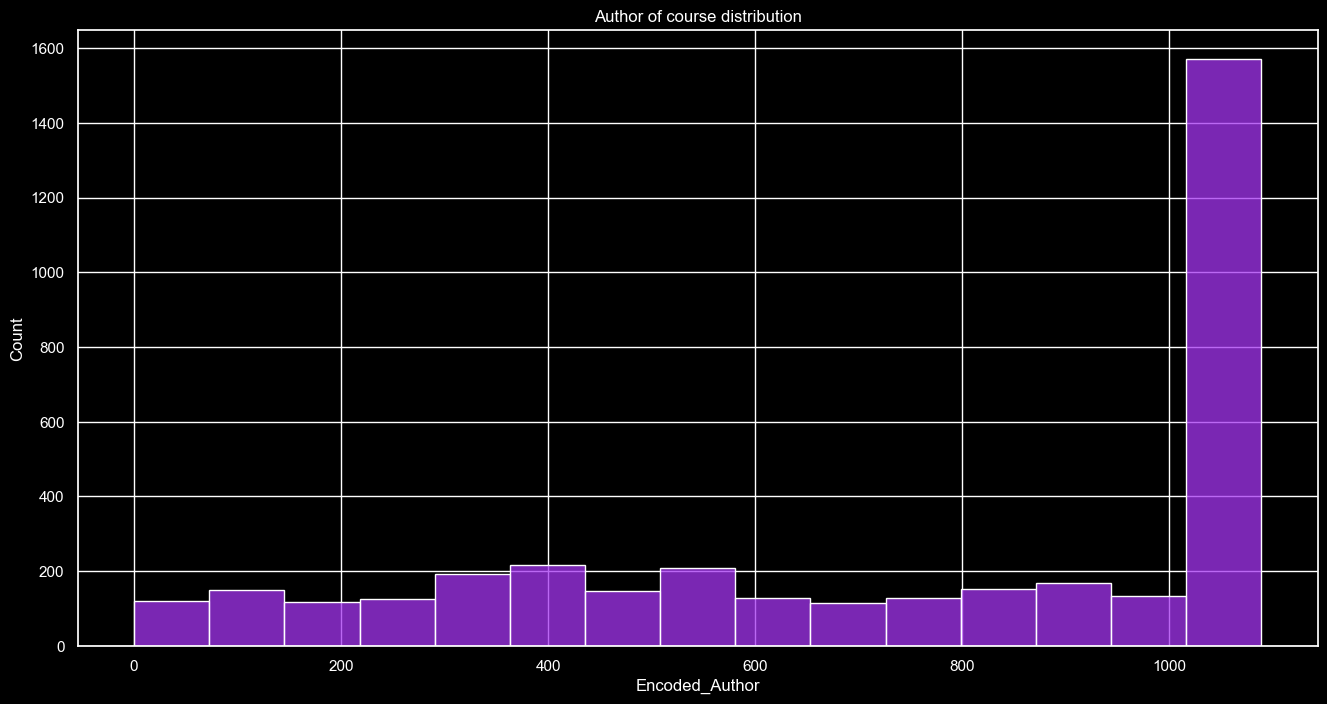

In [31]:
plt.figure(figsize=(16,8))
sns.histplot(data=df,x='Encoded_Author',color='#A435F0')
plt.title(label='Author of course distribution')
plt.show()

### Again, the large count at 1000 is due to the 'Unknown' authors.

# 4️⃣ Author dataframe

In [32]:
authorPrices = []
for i in df.Encoded_Author.unique():
    tempDF = df[df.Encoded_Author==i]
    authorPrices.append([np.mean(tempDF.price),
                         stats.mode(tempDF['Author'])[0][0],
                         len(tempDF),
                         np.mean(tempDF.rating),
                         sum(tempDF.num_subscribers),
                         sum(tempDF.num_reviews),
                         sum(tempDF.num_lectures),
                         np.mean(tempDF.content_duration),
                         stats.mode(tempDF.level)[0][0],
                         stats.mode(tempDF.subject)[0][0],
                         sum(tempDF.estimated_revenue)
                        ])
authorPrices.sort(reverse=True)
data = {
 'mean_price':[i[0] for i in authorPrices],
 'author':[i[1] for i in authorPrices],
 'courses':[i[2] for i in authorPrices],
 'mean_rating':[i[3] for i in authorPrices],
 'total_subscribers':[i[4] for i in authorPrices],
 'total_reviews':[i[5] for i in authorPrices],
 'total_lectures':[i[6] for i in authorPrices],
 'mean_content_duration':[i[7] for i in authorPrices],
 'mode_level':[i[8] for i in authorPrices],
 'mode_subject':[i[9] for i in authorPrices],
 'total_estimated_revenue':[i[10] for i in authorPrices] 
}
authorDF = pd.DataFrame(data)
noUnknowns = authorDF[authorDF['author']!='Unknown']
authorDF.head().style.background_gradient(cmap='Purples')

C:\Users\AES TECH\AppData\Local\Temp\ipykernel_5380\2113026447.py:5: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  stats.mode(tempDF['Author'])[0][0],
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "
C:\Users\AES TECH\AppData\Local\Temp\ipykernel_5380\2113026447.py:5: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https:/

,mean_price,author,courses,mean_rating,total_subscribers,total_reviews,total_lectures,mean_content_duration,mode_level,mode_subject,total_estimated_revenue
0,200.000000,eTraining Firm,1,0.870000,2506,21,76,6.000000,Beginner Level,Business Finance,501200
1,200.000000,Zac Gordon,1,0.470000,103,11,72,5.500000,All Levels,Web Development,20600
2,200.000000,Wealthy Education,3,0.626667,10146,700,143,4.333333,Beginner Level,Business Finance,2029200
3,200.000000,Vivek Vengala,2,0.840000,8386,55,68,2.750000,Beginner Level,Web Development,1677200
4,200.000000,VBA Finance,1,0.760000,2147,23,51,1.500000,Expert Level,Business Finance,429400


# 5️⃣ SQL analysis

### I will be removing the unknown authors from this analysis as they will skew the data.

In [30]:
from pathlib import Path
Path('database.db').touch()
conn = sqlite3.connect('database.db')
try:
    noUnknowns.to_sql('authors', conn, if_exists='append', index = False)
except:
    pass
c = conn.cursor()

In [33]:
list1 = c.execute('SELECT courses,AVG(mean_price) FROM authors GROUP BY courses').fetchall()
plt.figure(figsize=(16,8))
sns.regplot(x=[i[0] for i in list1],y=[i[1] for i in list1],color='#A435F0')
plt.title(label='Average price of a course grouped by number of courses published by an author')
plt.xlabel(xlabel='Courses Published')
plt.ylabel(ylabel='Average Price')
plt.show()

NameError: name 'c' is not defined

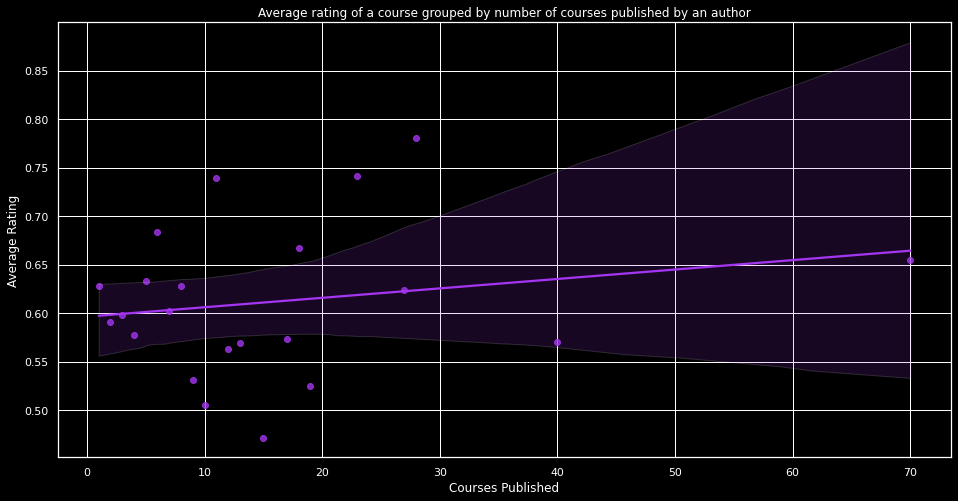

In [32]:
list2 = c.execute('SELECT courses,AVG(mean_rating) FROM authors GROUP BY courses').fetchall()
plt.figure(figsize=(16,8))
sns.regplot(x=[i[0] for i in list2],y=[i[1] for i in list2],color='#A435F0')
plt.title(label='Average rating of a course grouped by number of courses published by an author')
plt.xlabel(xlabel='Courses Published')
plt.ylabel(ylabel='Average Rating')
plt.show()

In [34]:
list3 = c.execute('SELECT courses, COUNT(courses) FROM authors GROUP BY courses').fetchall()
plt.figure(figsize=(16,8))
sns.barplot(x=[i[0] for i in list3],y=[i[1] for i in list3],color='#A435F0')
plt.title(label='Distribution of courses published on Udemy by authors')
plt.xlabel(xlabel='Courses Published')
plt.ylabel(ylabel='Count')
plt.show()

NameError: name 'c' is not defined

In [35]:
list4 = c.execute('SELECT mean_price, COUNT(mean_price) FROM authors GROUP BY mean_price').fetchall()
plt.figure(figsize=(16,8))
sns.barplot(x=[round(i[0],2) for i in list4],y=[i[1] for i in list4],color='#A435F0')
plt.title(label='Distribution of mean prices published on Udemy by authors')
plt.xlabel(xlabel='Mean Price')
plt.ylabel(ylabel='Count')
plt.xticks(rotation=90,fontsize=7)
plt.show()

NameError: name 'c' is not defined

### Seems like a lot of courses are given an arbitary value of 20.

In [36]:
list5 = c.execute('''SELECT author,
                  total_subscribers,
                  mode_subject
                  FROM authors ORDER BY total_subscribers DESC LIMIT 10
                  ''').fetchall()
plt.figure(figsize=(16,8))
sns.barplot(x=[i[0]+'\n'+i[2] for i in list5],y=[i[1] for i in list5],color='#A435F0')
plt.title(label='Top 10 most subscribed authors')
plt.xlabel(xlabel='Author')
plt.ylabel(ylabel='Subscriber Count')
plt.xticks(fontsize=10,rotation=45)
plt.show()

NameError: name 'c' is not defined

In [37]:
list6 = c.execute('''
          SELECT
          author,
          mean_rating,
          courses,
          total_reviews,
          mode_subject
          FROM authors
          WHERE total_reviews > 500 AND courses > 5
          ORDER BY mean_rating DESC
          LIMIT 10
          ''').fetchall()
plt.figure(figsize=(16,8))
sns.barplot(x=[i[0]+'\n'+i[4] for i in list6],y=[i[1] for i in list6],color='#A435F0')
plt.title(label='Top 10 consistently good authors (Greater that 500 reviews and more than 5 courses published)')
plt.xlabel(xlabel='Author')
plt.ylabel(ylabel='Mean_rating')
plt.xticks(fontsize=10,rotation=45)
plt.show()

NameError: name 'c' is not defined

In [38]:
list7 = c.execute('''
    SELECT
    author,
    courses,
    mode_subject
    FROM authors
    ORDER BY courses DESC
    LIMIT 10
''').fetchall()
plt.figure(figsize=(16,8))
sns.barplot(x=[i[0]+'\n'+i[2] for i in list7],y=[i[1] for i in list7],color='#A435F0')
plt.title(label='Top 10 authors with the most published courses')
plt.xlabel(xlabel='Author')
plt.ylabel(ylabel='Count')
plt.xticks(fontsize=10,rotation=45)
plt.show()

NameError: name 'c' is not defined

In [39]:
list8 = c.execute('''
    SELECT
    author,
    courses,
    mean_rating,
    mode_subject
    FROM authors
    ORDER BY courses DESC
    LIMIT 10
''').fetchall()
plt.figure(figsize=(16,8))
sns.barplot(x=[i[0]+'\n'+i[3] for i in list8],y=[i[2] for i in list8],color='#A435F0')
plt.title(label='Top 10 authors with the most published courses and their mean rating')
plt.xlabel(xlabel='Author')
plt.ylabel(ylabel='Mean_rating')
plt.xticks(fontsize=10,rotation=45)
plt.show()

NameError: name 'c' is not defined

In [40]:
list9 = c.execute('''
    SELECT
    author,
    courses,
    total_estimated_revenue,
    mode_subject
    FROM authors
    ORDER BY total_estimated_revenue DESC
    LIMIT 10
''').fetchall()
plt.figure(figsize=(16,8))
sns.barplot(x=[i[0]+'\n'+str(i[1])+' Courses' for i in list9],
            y=[i[2] for i in list9],color='#A435F0')
plt.title(label='Top 10 authors by estimated revenue')
plt.xlabel(xlabel='Author')
plt.ylabel(ylabel='Revenue')
newLabels = list(plt.yticks()[0])
plt.yticks(ticks=list(plt.yticks()[0]),labels=["{:,}".format(i) for i in newLabels])
plt.xticks(fontsize=10,rotation=45)
plt.show()

NameError: name 'c' is not defined

### We observe that some of the most subscribed authors also publish the most and have the approach of quantity over quality. The top 10 most subscribed authors base their content on web developement.

### Hari Swaminathan seems to be highly regarded as one of the most consistent authors with a high number of courses published and a high mean rating. Hari does not feature on the most subscribed authors as Hari deals largely with finance and as we know, most of the subscribers on Udemy subscribe to free web development courses. However some of the top earners on Udemy, minus the commission Udemy takes, still do extremely well from their courses.

In [41]:
ratings = []
prices = []
courses = []
subscribers = []
revenue = []
for i in df['Author']:
    ratings.append(list(authorDF[authorDF.author == i]['mean_rating'])[0])
    prices.append(list(authorDF[authorDF.author == i]['mean_price'])[0])
    if i == 'Unknown':
        courses.append(1)
        subscribers.append(np.mean(df['num_subscribers']))
        revenue.append(np.mean(df['estimated_revenue']))
    else:
        courses.append(list(authorDF[authorDF.author == i]['courses'])[0])
        subscribers.append(list(authorDF[authorDF.author == i]['total_subscribers'])[0]) 
        revenue.append(list(authorDF[authorDF.author == i]['total_estimated_revenue'])[0])
    
df['author_mean_rating'] = ratings
df['author_mean_price'] = prices
df['courses_by_author'] = courses
df['subscribers_by_author'] = subscribers
df.head().style.background_gradient(cmap='Purples')

,course_id,course_title,url,price,num_subscribers,num_reviews,num_lectures,level,rating,content_duration,published_timestamp,subject,Date,Free/Paid,estimated_revenue,Author,Encoded_Author,author_mean_rating,author_mean_price,courses_by_author,subscribers_by_author
0,41295,Learn HTML5 Programming From Scratch,https://www.udemy.com/learn-html5-programming-from-scratch/,0,268923,8629,45,Beginner Level,0.820000,10.500000,2013-02-14T07:03:41Z,Web Development,2013-02-14,Free,0,Eduonix Learning Solutions,311,0.570500,39.500000,40,568817.000000
1,59014,Coding for Entrepreneurs Basic,https://www.udemy.com/coding-for-entrepreneurs-basic/,0,161029,279,27,Expert Level,0.690000,3.500000,2013-06-09T15:51:55Z,Web Development,2013-06-09,Free,0,Justin Mitchel,525,0.590000,113.888889,9,245821.000000
2,625204,The Web Developer Bootcamp,https://www.udemy.com/the-web-developer-bootcamp/,200,121584,27445,342,Beginner Level,0.890000,43.000000,2015-11-02T21:13:27Z,Web Development,2015-11-02,Paid,24316800,Colt Steele,208,0.890000,200.000000,1,121584.000000
3,173548,Build Your First Website in 1 Week with HTML5 and CSS3,https://www.udemy.com/build-your-first-website-in-1-week/,0,120291,5924,30,All Levels,0.780000,3.000000,2014-04-08T16:21:30Z,Web Development,2014-04-08,Free,0,Ryan Bonhardt,857,0.835000,25.000000,2,139109.000000
4,764164,The Complete Web Developer Course 2.0,https://www.udemy.com/the-complete-web-developer-course-2/,200,114512,22412,304,Beginner Level,0.550000,30.500000,2016-03-08T22:28:36Z,Web Development,2016-03-08,Paid,22902400,Rob Percival,830,0.610000,152.500000,6,174810.000000


# 6️⃣ Label encoding

In [42]:
le = preprocessing.LabelEncoder()
le.fit(list(df['Free/Paid']))
newList = le.transform(list(df['Free/Paid']))
df['Encoded_Free/Paid'] = newList

le = preprocessing.LabelEncoder()
le.fit(list(df['Date']))
newList = le.transform(list(df['Date']))
df['Encoded_Date'] = newList

le = preprocessing.LabelEncoder()
le.fit(list(df['subject']))
newList = le.transform(list(df['subject']))
df['Encoded_Subject'] = newList

le = preprocessing.LabelEncoder()
le.fit(list(df['level']))
newList = le.transform(list(df['level']))
df['Encoded_Level'] = newList

le = preprocessing.LabelEncoder()
le.fit(list(df['Date']))
newList = le.transform(list(df['Date']))
df['Encoded_Date'] = newList

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3676 entries, 0 to 3675
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   course_id              3676 non-null   int64  
 1   course_title           3676 non-null   object 
 2   url                    3676 non-null   object 
 3   price                  3676 non-null   int64  
 4   num_subscribers        3676 non-null   int64  
 5   num_reviews            3676 non-null   int64  
 6   num_lectures           3676 non-null   int64  
 7   level                  3676 non-null   object 
 8   rating                 3676 non-null   float64
 9   content_duration       3676 non-null   float64
 10  published_timestamp    3676 non-null   object 
 11  subject                3676 non-null   object 
 12  Date                   3676 non-null   object 
 13  Free/Paid              3676 non-null   object 
 14  estimated_revenue      3676 non-null   int64  
 15  Auth

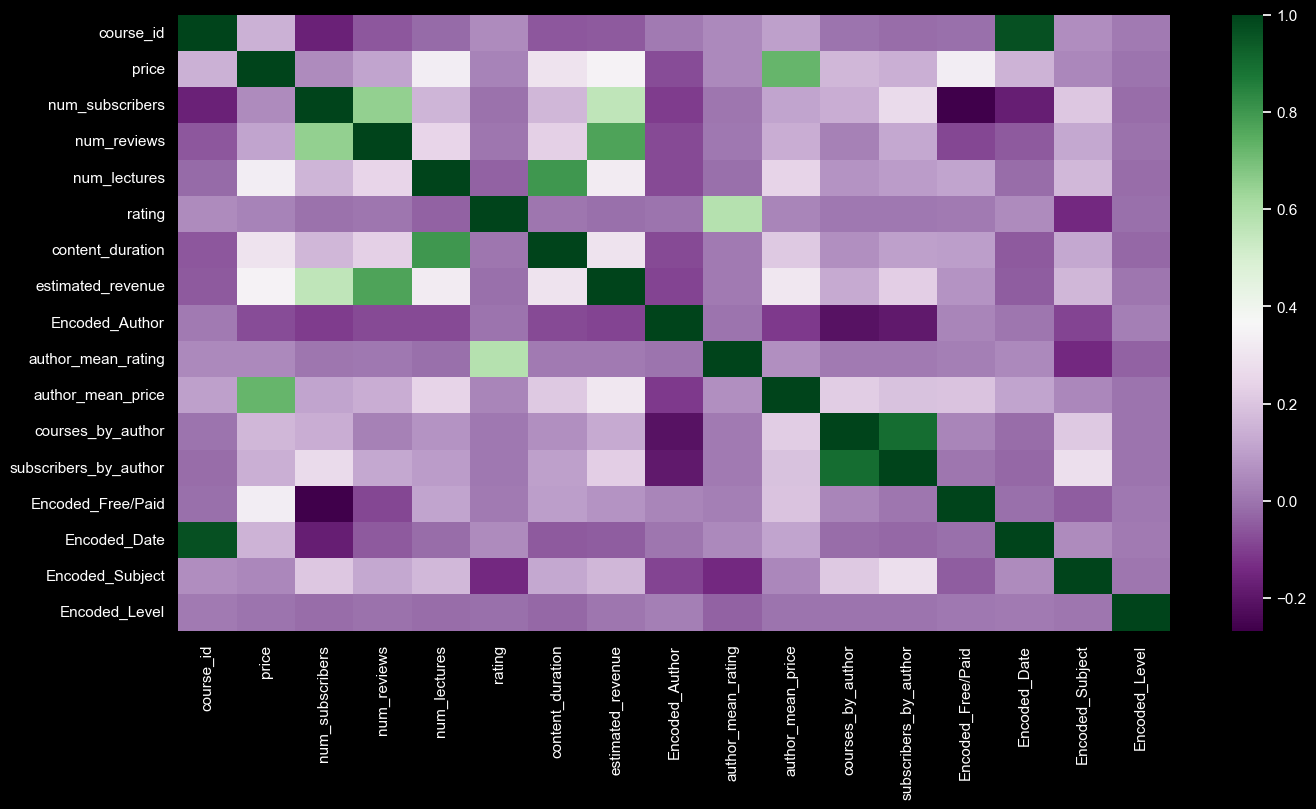

In [44]:
plt.figure(figsize=(16,8))
sns.heatmap(df.corr(),cmap='PRGn')
plt.show()

# 7️⃣ Modelling

11.631095551894564


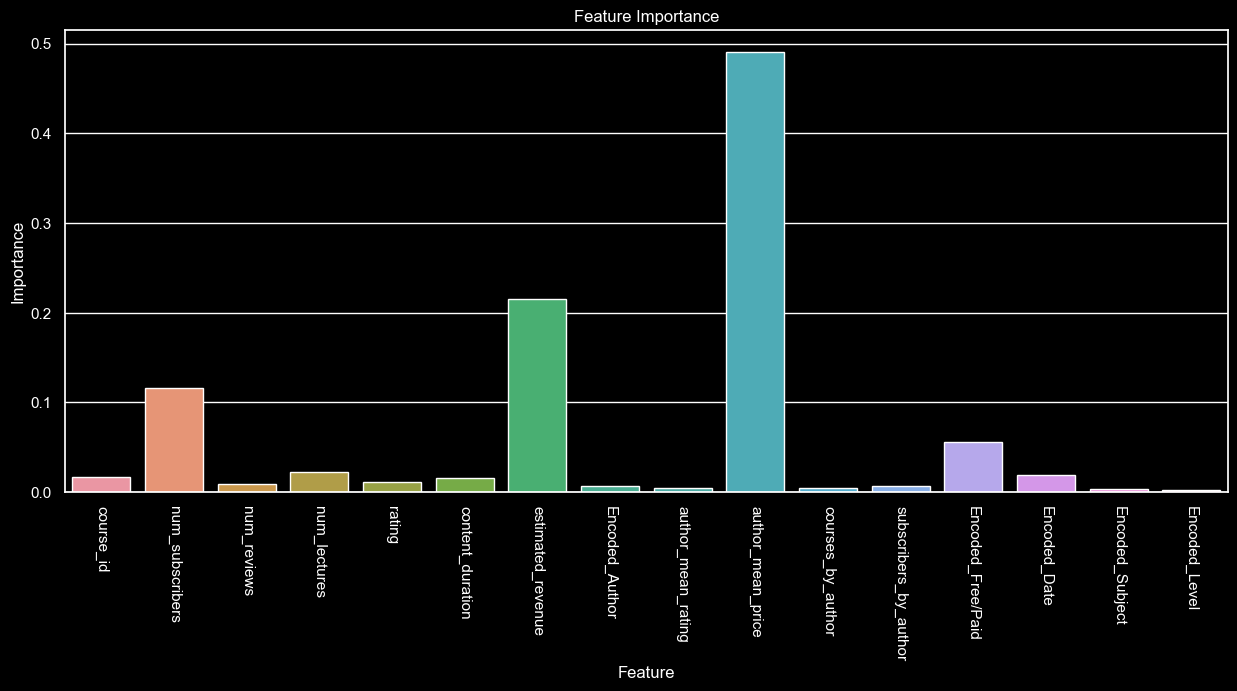

In [45]:
numericalFeatures = []
for i in df.columns:
    if df[i].dtype != 'object':
        numericalFeatures.append(i)
features = [i for i in numericalFeatures if i != 'price']
X = df[features]
y = df['price']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = RandomForestRegressor(random_state=42)

model.fit(X_train,y_train)

print(mean_absolute_error(y_test, model.predict(X_test))) 

importance = model.feature_importances_
plt.figure(figsize=(15,6))
sns.barplot(x=[i for i in features],y=importance)
plt.yticks(color='white')
plt.xticks(color='white',rotation=-90)
plt.xlabel(xlabel='Feature',color='white')
plt.title(label='Feature Importance')
plt.ylabel(ylabel='Importance',color='white')
plt.show()

# 8️⃣ BorutaShap feature selection

In [47]:
# from BorutaShap import BorutaShap

# Feature_Selector = BorutaShap(importance_measure='shap', classification=False)

# Feature_Selector.fit(X=X_train, y=y_train, n_trials=50, random_state=0)

# OUTPUT
# 9 attributes confirmed important: ['Encoded_Date', 'Encoded_Free/Paid',
# 'content_duration', 'course_id', 'author_mean_price', 'estimated_revenue',
# 'num_lectures', 'num_subscribers', 'subscribers_by_author']

# 7 attributes confirmed unimportant: ['author_mean_rating', 'Encoded_Subject',
# 'courses_by_author', 'Encoded_Level', 'rating', 'Encoded_Author', 'num_reviews']

# 0 tentative attributes remains: []

### This code takes about an hour to complete so I will leave it commented out

10.772734761120262


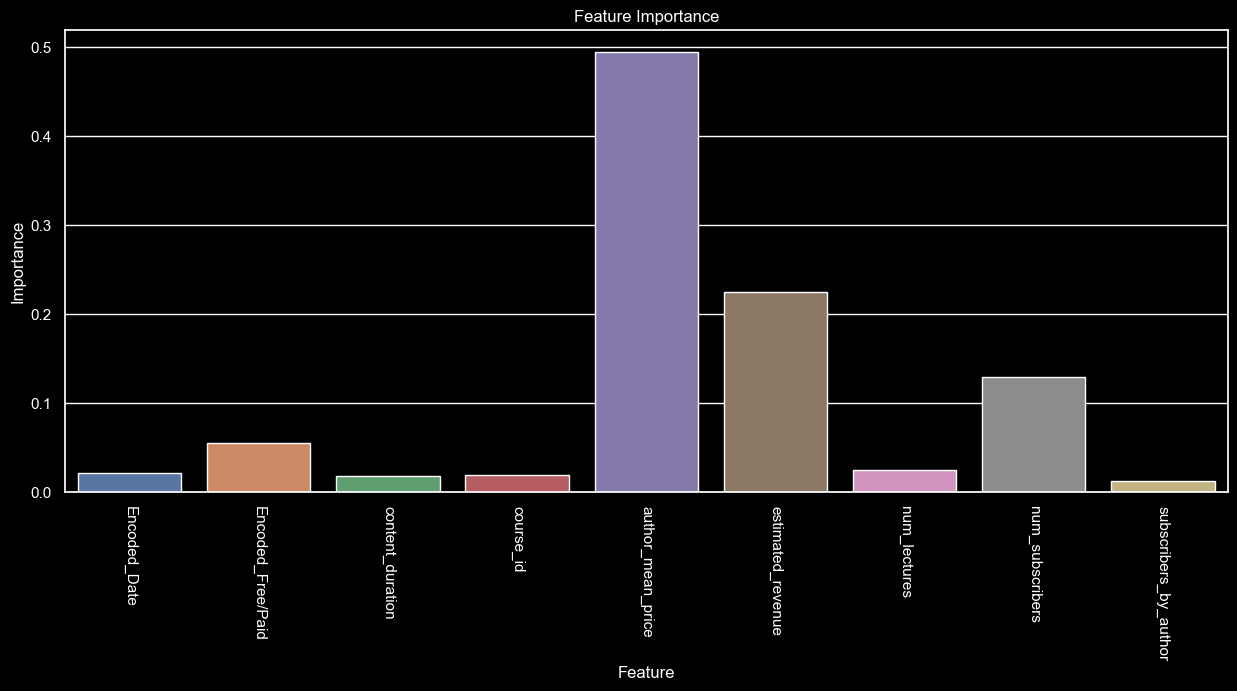

In [48]:
importantFeatures = ['Encoded_Date', 'Encoded_Free/Paid',
'content_duration', 'course_id', 'author_mean_price', 'estimated_revenue',
'num_lectures', 'num_subscribers', 'subscribers_by_author']

X = df[importantFeatures]
y = df['price']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = RandomForestRegressor(random_state=42)

model.fit(X_train,y_train)

print(mean_absolute_error(y_test, model.predict(X_test))) 

importance = model.feature_importances_
plt.figure(figsize=(15,6))
sns.barplot(x=[i for i in importantFeatures],y=importance)
plt.yticks(color='white')
plt.xticks(color='white',rotation=-90)
plt.xlabel(xlabel='Feature',color='white')
plt.title(label='Feature Importance')
plt.ylabel(ylabel='Importance',color='white')
plt.show()

# 9️⃣ XGBoost model

In [49]:
xgbModel = xg.XGBRegressor(seed=42)

xgbModel.fit(X_train,y_train)

print(mean_absolute_error(y_test, xgbModel.predict(X_test))) 

7.94329867481455


In [50]:
param_grid = { 
    'n_estimators': [50,100,150,200,250,300],
    'max_depth' : [5,6,7,8,9,10],
    'learning_rate' : [0.2,0.3,0.4]
}

model = RandomForestRegressor(random_state=42)
clf = GridSearchCV(estimator=xgbModel, param_grid=param_grid, cv= 5, verbose=1)
clf.fit(X_train, y_train)

mean_absolute_error(y_test, clf.predict(X_test)) 

Fitting 5 folds for each of 108 candidates, totalling 540 fits


7.141921691987756